In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import warnings
warnings.filterwarnings(action='ignore')

### Read Data

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [3]:
df.shape

(69999, 172)

In [4]:
print(df.dtypes[:60], df.dtypes[60:120], df.dtypes[120:])

id                        int64
circle_id                 int64
loc_og_t2o_mou          float64
std_og_t2o_mou          float64
loc_ic_t2o_mou          float64
last_date_of_month_6     object
last_date_of_month_7     object
last_date_of_month_8     object
arpu_6                  float64
arpu_7                  float64
arpu_8                  float64
onnet_mou_6             float64
onnet_mou_7             float64
onnet_mou_8             float64
offnet_mou_6            float64
offnet_mou_7            float64
offnet_mou_8            float64
roam_ic_mou_6           float64
roam_ic_mou_7           float64
roam_ic_mou_8           float64
roam_og_mou_6           float64
roam_og_mou_7           float64
roam_og_mou_8           float64
loc_og_t2t_mou_6        float64
loc_og_t2t_mou_7        float64
loc_og_t2t_mou_8        float64
loc_og_t2m_mou_6        float64
loc_og_t2m_mou_7        float64
loc_og_t2m_mou_8        float64
loc_og_t2f_mou_6        float64
loc_og_t2f_mou_7        float64
loc_og_t

### Remove columns having more than 70% null values

In [5]:
columns_70 = []
for col in df.columns:
    print(col, '<--------->', df[col].isna().sum(),'<--------->', round((df[col].isna().sum()/69999)*100,2))
    if round((df[col].isna().sum()/69999)*100,2) < 70:
        columns_70.append(col)
df = df[columns_70]

id <---------> 0 <---------> 0.0
circle_id <---------> 0 <---------> 0.0
loc_og_t2o_mou <---------> 702 <---------> 1.0
std_og_t2o_mou <---------> 702 <---------> 1.0
loc_ic_t2o_mou <---------> 702 <---------> 1.0
last_date_of_month_6 <---------> 0 <---------> 0.0
last_date_of_month_7 <---------> 399 <---------> 0.57
last_date_of_month_8 <---------> 733 <---------> 1.05
arpu_6 <---------> 0 <---------> 0.0
arpu_7 <---------> 0 <---------> 0.0
arpu_8 <---------> 0 <---------> 0.0
onnet_mou_6 <---------> 2768 <---------> 3.95
onnet_mou_7 <---------> 2687 <---------> 3.84
onnet_mou_8 <---------> 3703 <---------> 5.29
offnet_mou_6 <---------> 2768 <---------> 3.95
offnet_mou_7 <---------> 2687 <---------> 3.84
offnet_mou_8 <---------> 3703 <---------> 5.29
roam_ic_mou_6 <---------> 2768 <---------> 3.95
roam_ic_mou_7 <---------> 2687 <---------> 3.84
roam_ic_mou_8 <---------> 3703 <---------> 5.29
roam_og_mou_6 <---------> 2768 <---------> 3.95
roam_og_mou_7 <---------> 2687 <---------> 3.

### Null Value Treatment

In [6]:
#Check columns with null values
for col in df.columns:
    if round((df[col].isna().sum()/69999)*100,2) > 0:
        print(col, '<--------->', df[col].isna().sum(),'<--------->', round((df[col].isna().sum()/69999)*100,2),'%')

loc_og_t2o_mou <---------> 702 <---------> 1.0 %
std_og_t2o_mou <---------> 702 <---------> 1.0 %
loc_ic_t2o_mou <---------> 702 <---------> 1.0 %
last_date_of_month_7 <---------> 399 <---------> 0.57 %
last_date_of_month_8 <---------> 733 <---------> 1.05 %
onnet_mou_6 <---------> 2768 <---------> 3.95 %
onnet_mou_7 <---------> 2687 <---------> 3.84 %
onnet_mou_8 <---------> 3703 <---------> 5.29 %
offnet_mou_6 <---------> 2768 <---------> 3.95 %
offnet_mou_7 <---------> 2687 <---------> 3.84 %
offnet_mou_8 <---------> 3703 <---------> 5.29 %
roam_ic_mou_6 <---------> 2768 <---------> 3.95 %
roam_ic_mou_7 <---------> 2687 <---------> 3.84 %
roam_ic_mou_8 <---------> 3703 <---------> 5.29 %
roam_og_mou_6 <---------> 2768 <---------> 3.95 %
roam_og_mou_7 <---------> 2687 <---------> 3.84 %
roam_og_mou_8 <---------> 3703 <---------> 5.29 %
loc_og_t2t_mou_6 <---------> 2768 <---------> 3.95 %
loc_og_t2t_mou_7 <---------> 2687 <---------> 3.84 %
loc_og_t2t_mou_8 <---------> 3703 <---------

In [7]:
# Delete Date columns
date_col = []
for col in df.columns:
    if 'date' in col:
        date_col.append(col)
df.drop(columns=date_col, inplace=True)

In [8]:
#Fill MOU and other outgoing, incoming call null values with 0
df.fillna(0, inplace=True)

In [9]:
df.isna().sum()

id                   0
circle_id            0
loc_og_t2o_mou       0
std_og_t2o_mou       0
loc_ic_t2o_mou       0
                    ..
aon                  0
aug_vbc_3g           0
jul_vbc_3g           0
jun_vbc_3g           0
churn_probability    0
Length: 136, dtype: int64

### Feature Engineering

In [10]:
#find all the month columns
month_col = []
distinct_features = []
for col in df.columns:
    if '6' in col or '7' in col or '8' in col:
        month_col.append(col)
        col = col.split('_')[:-1]
        col = '_'.join(col)
        distinct_features.append(col)
        
df[month_col]

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,...,0,0,0,0,0,0,0,0,0,0
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,...,0,0,0,0,0,1,0,0,0,0
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,...,0,0,0,0,0,0,0,0,0,0
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,...,0,7,6,6,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,14.96,...,0,0,6,1,0,0,0,0,1,0
69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,0.00,...,0,0,0,0,0,0,0,0,0,0
69996,372.088,258.374,279.782,77.13,68.44,78.44,335.54,227.94,263.84,0.00,...,0,0,0,0,0,0,0,0,0,0
69997,238.575,245.414,145.062,14.01,7.64,6.71,30.34,16.68,12.56,25.06,...,0,0,0,0,1,1,1,0,0,0


In [11]:
df.shape

(69999, 136)

In [12]:
# Find the avg and difference for all these columns
for feature in set(distinct_features):
    df[feature+'_avg'] = (df[feature+'_6'] + df[feature+'_7'])/2
    df[feature+'_diff'] = df[feature+'_avg'] - df[feature+'_8']
    df.drop(columns=[feature+'_6', feature+'_7', feature+'_8'], inplace=True)

In [13]:
df['vbc_3g_avg'] = df['jun_vbc_3g'] + df['jul_vbc_3g']
df['vbc_3g_avg'] = df['vbc_3g_avg']/2
df['vbc_3g_diff'] = df['vbc_3g_avg'] - df['aug_vbc_3g']
df.drop(columns=['aug_vbc_3g', 'jun_vbc_3g', 'jul_vbc_3g'], inplace=True)

In [14]:
df.iloc[:, 10:].head()

,total_ic_mou_diff,offnet_mou_avg,offnet_mou_diff,spl_og_mou_avg,spl_og_mou_diff,monthly_2g_avg,monthly_2g_diff,loc_og_mou_avg,loc_og_mou_diff,sachet_3g_avg,...,vol_3g_mb_avg,vol_3g_mb_diff,ic_others_avg,ic_others_diff,og_others_avg,og_others_diff,isd_og_mou_avg,isd_og_mou_diff,vbc_3g_avg,vbc_3g_diff
0,-8.120,64.460,62.130,4.415,4.415,0.0,0.0,11.785,9.175,0.0,...,0.00,0.00,0.9,0.90,0.19,0.19,0.0,0.0,0.0,0.0
1,-3.600,12.995,-17.895,15.365,-16.295,0.0,0.0,0.000,0.000,0.0,...,1.98,1.98,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0
2,42.420,68.020,68.020,2.135,2.135,0.0,0.0,18.810,18.810,0.0,...,0.00,0.00,0.0,-0.25,0.00,0.00,0.0,0.0,0.0,0.0
3,-11.195,73.620,23.390,12.040,-13.570,0.0,0.0,46.875,23.245,0.0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0
4,-12.860,47.550,37.920,8.500,8.500,0.0,0.0,42.425,26.665,0.5,...,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0


### EDA

#### Univariate

###### Delete the columns with 0 variance

id std: 20207.11508355411
circle_id std: 0.0
loc_og_t2o_mou std: 0.0
std_og_t2o_mou std: 0.0
loc_ic_t2o_mou std: 0.0
aon std: 952.426320924281
churn_probability std: 0.30250203588069513
roam_ic_mou_avg std: 47.38553050007381
roam_ic_mou_diff std: 46.65704008342823
total_ic_mou_avg std: 277.330227382886
total_ic_mou_diff std: 182.15425636595023
offnet_mou_avg std: 294.41578435877364
offnet_mou_diff std: 234.19516108180616
spl_og_mou_avg std: 16.428603723505233
spl_og_mou_diff std: 15.760867737496932
monthly_2g_avg std: 0.2621876274561139
monthly_2g_diff std: 0.2581284632046329
loc_og_mou_avg std: 234.05761829722218
loc_og_mou_diff std: 141.47200056730426
sachet_3g_avg std: 0.5480962359434245
sachet_3g_diff std: 0.5386134123170204
total_rech_num_avg std: 6.439144379606272
total_rech_num_diff std: 5.507559979238115
loc_og_t2c_mou_avg std: 5.539193962007376
loc_og_t2c_mou_diff std: 6.123714251429994
onnet_mou_avg std: 279.960557401265
onnet_mou_diff std: 210.2898005861384
std_ic_t2o_mou_av

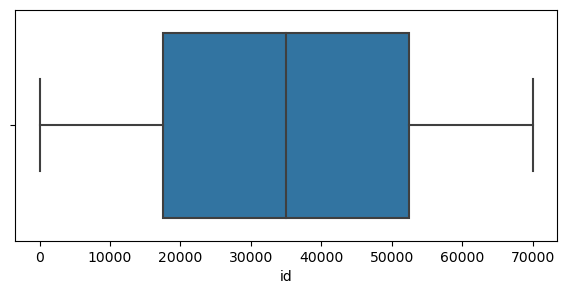

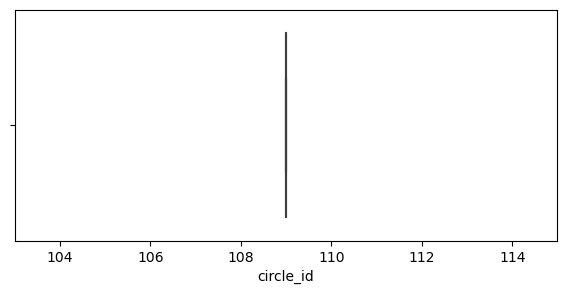

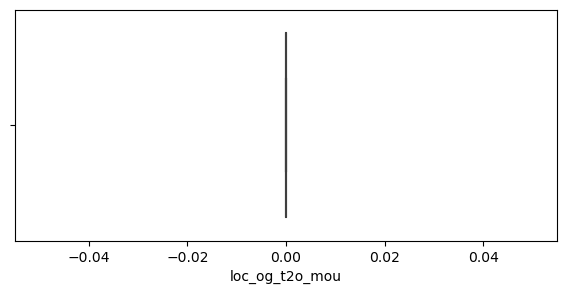

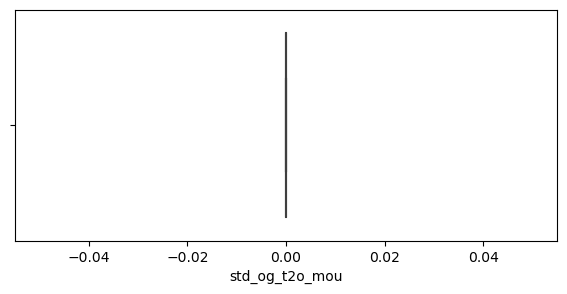

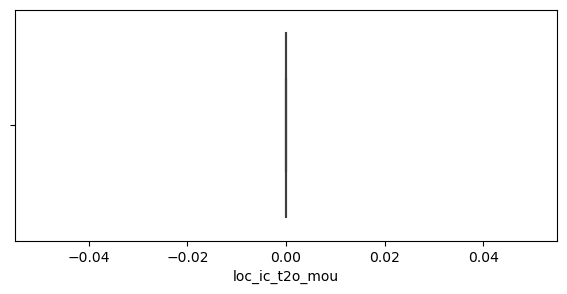

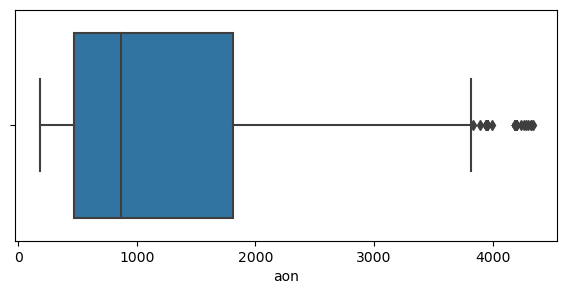

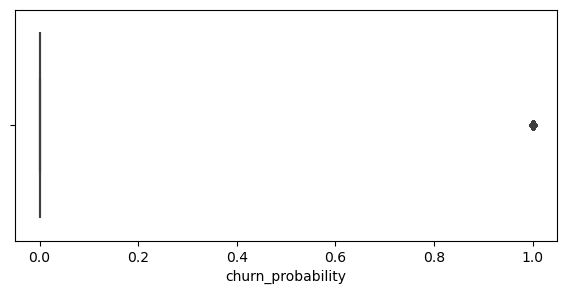

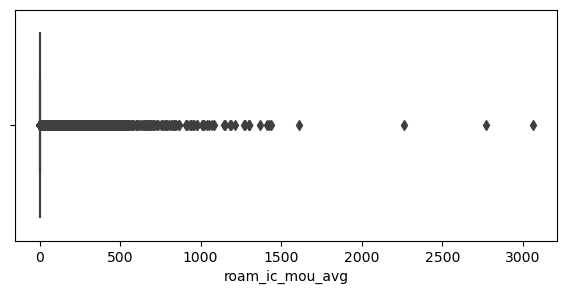

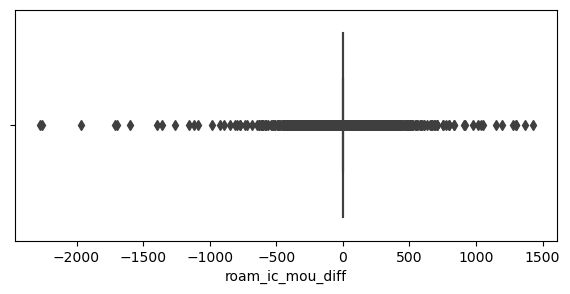

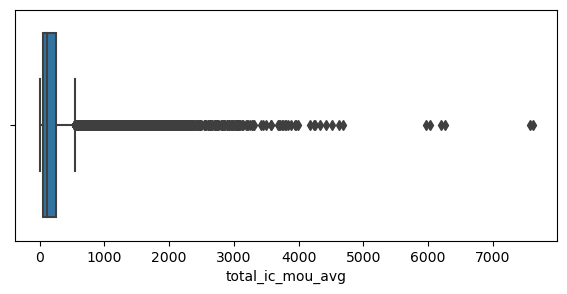

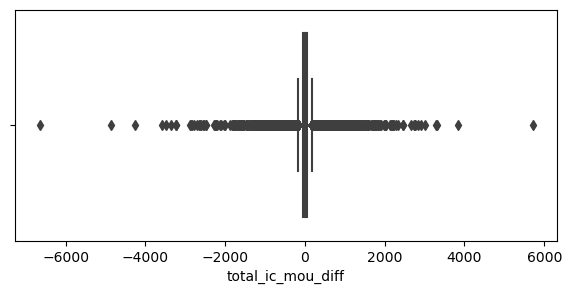

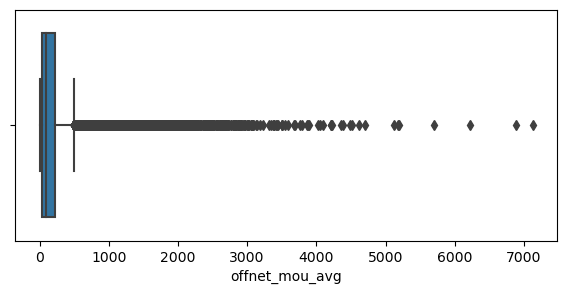

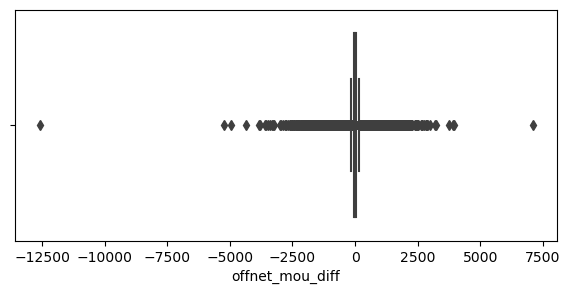

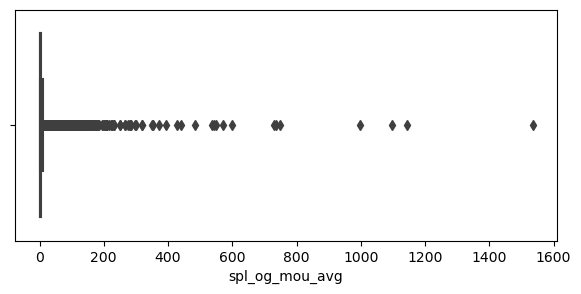

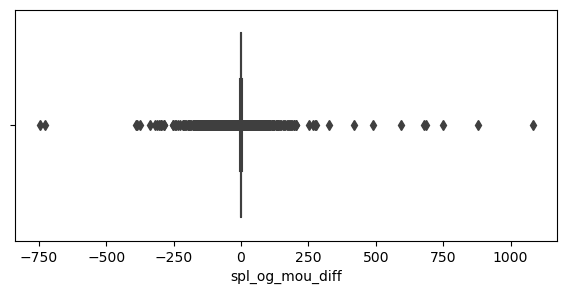

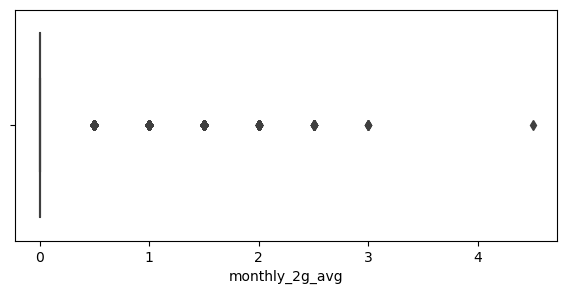

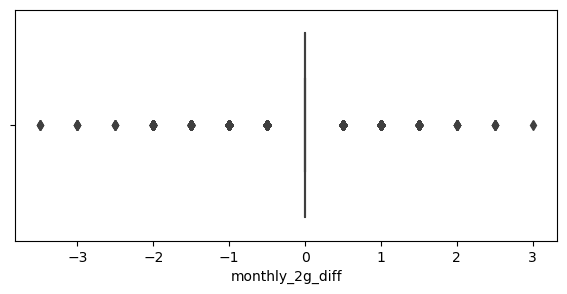

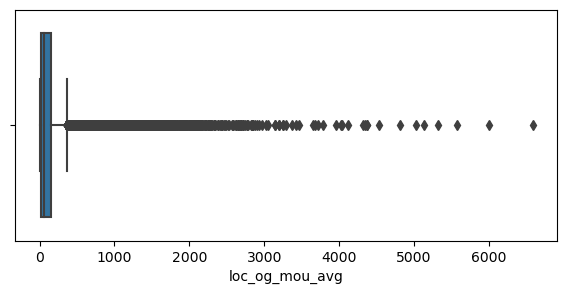

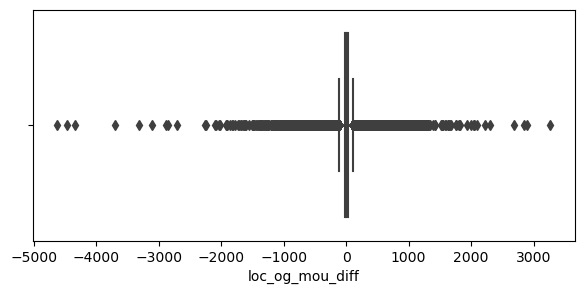

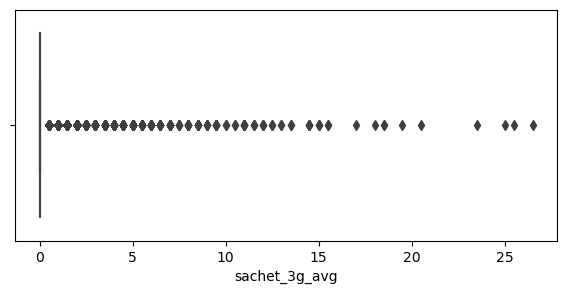

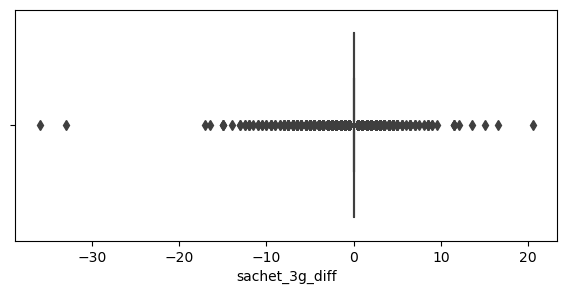

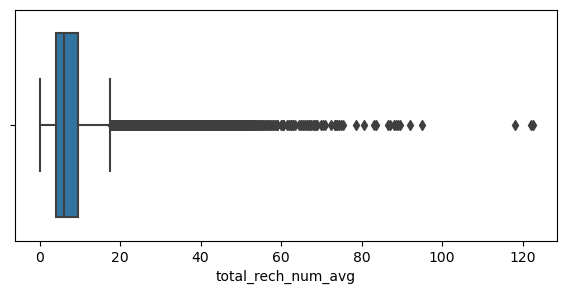

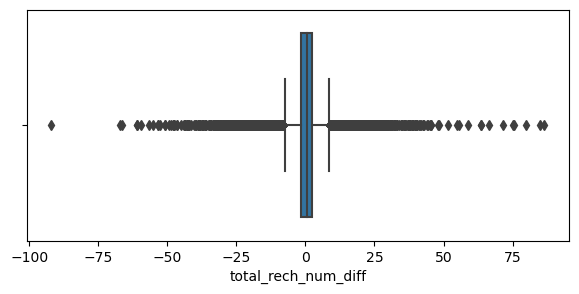

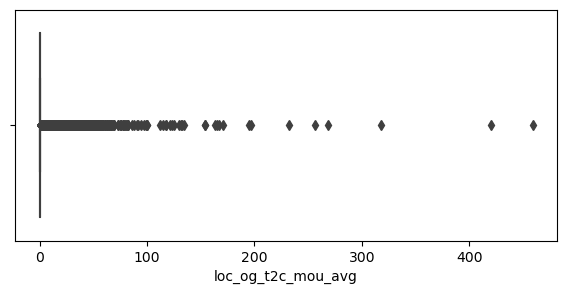

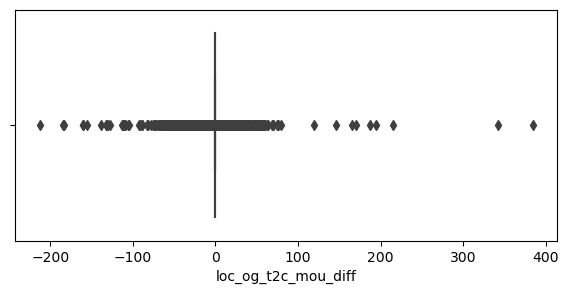

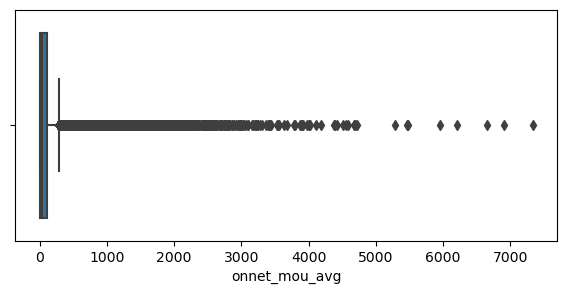

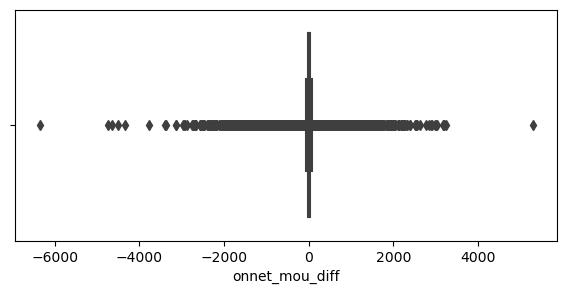

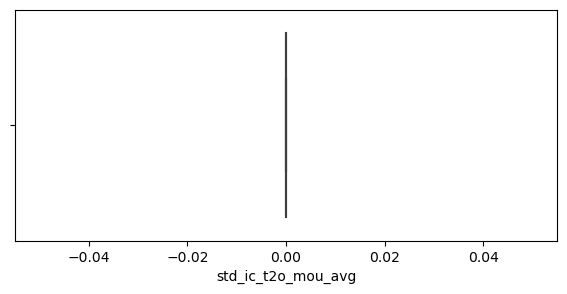

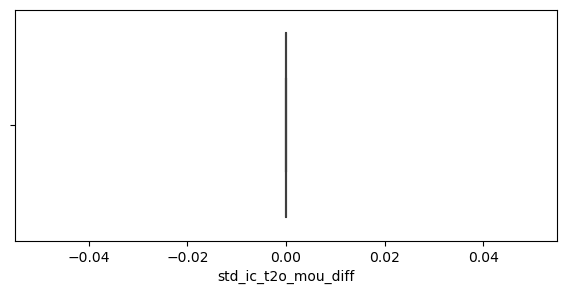

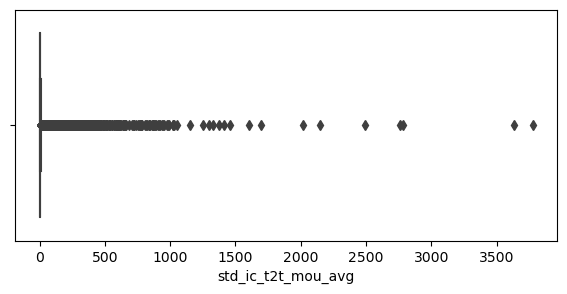

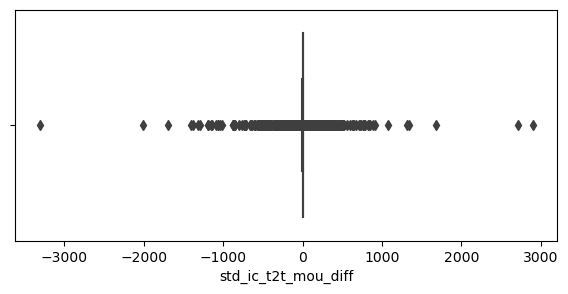

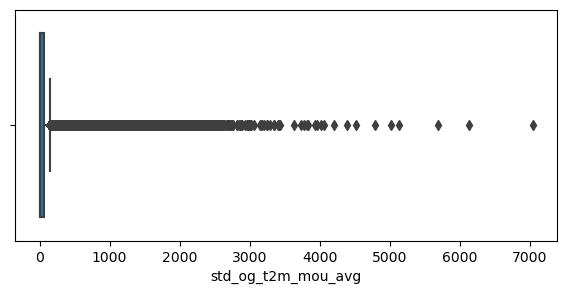

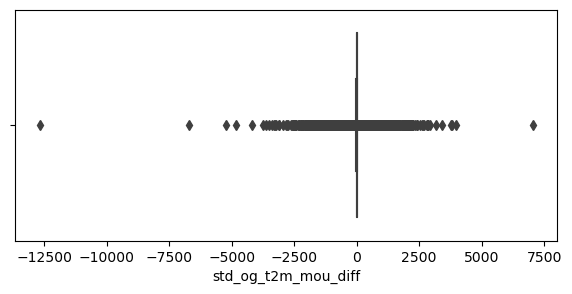

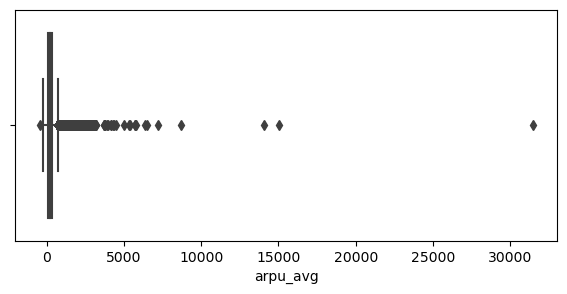

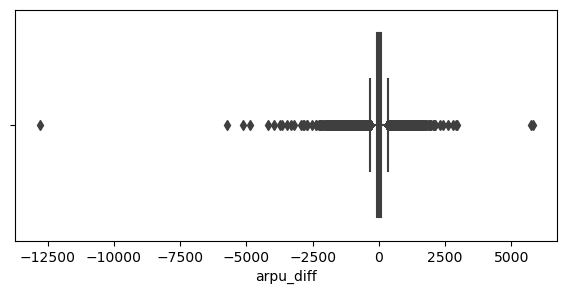

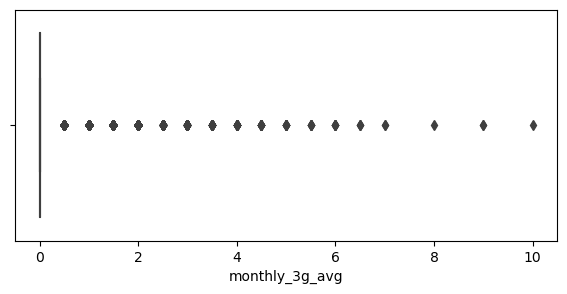

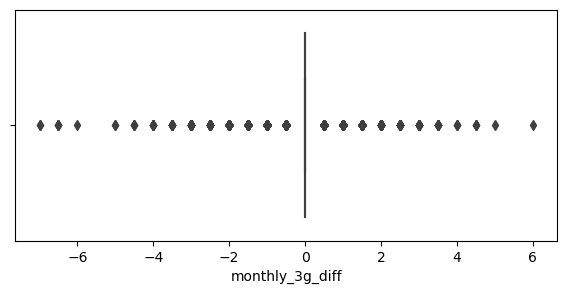

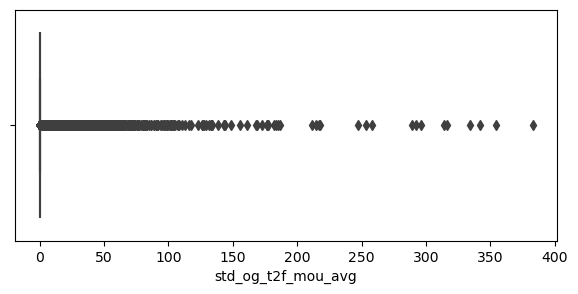

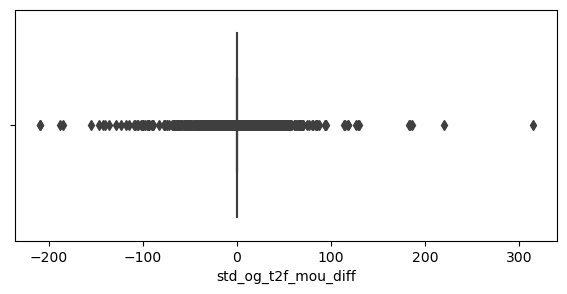

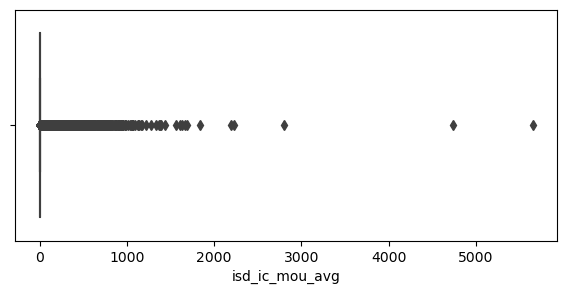

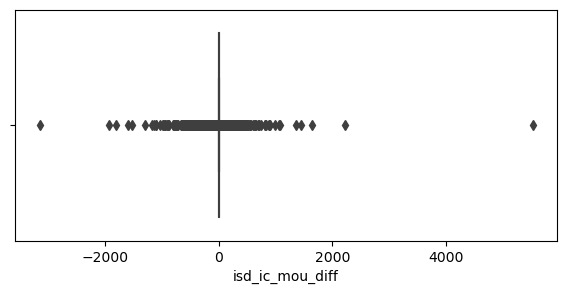

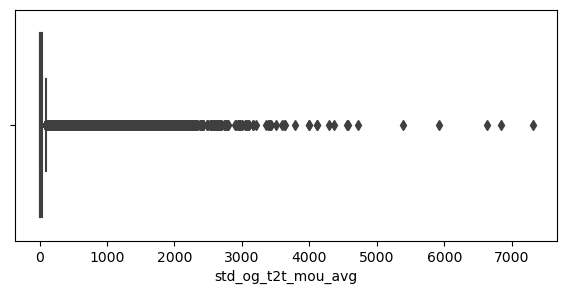

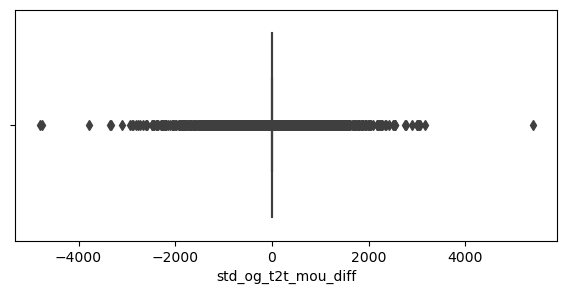

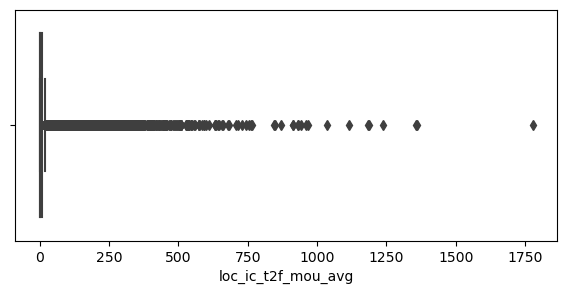

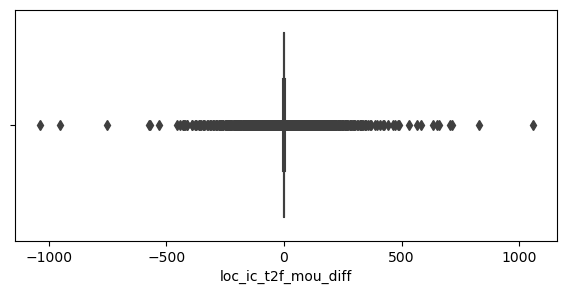

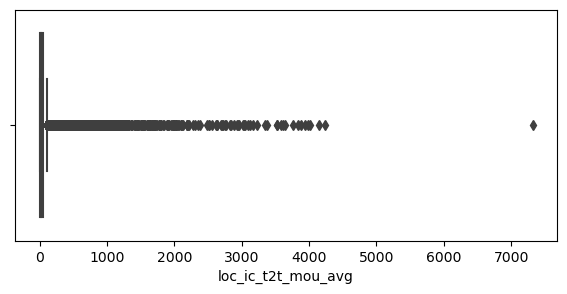

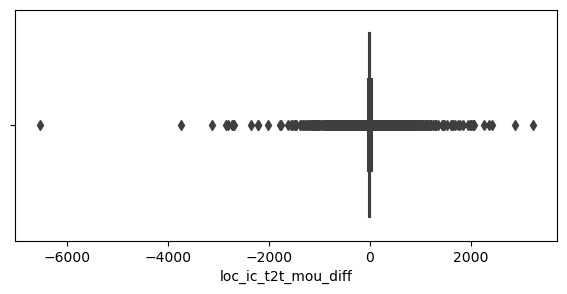

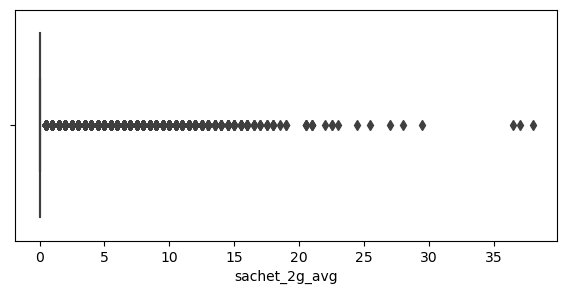

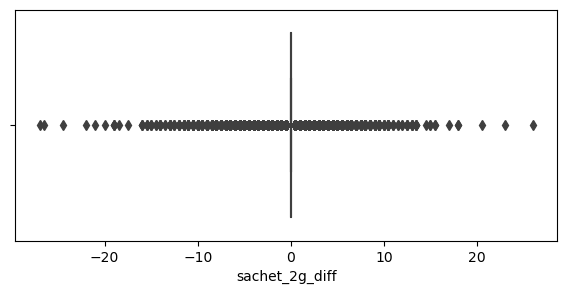

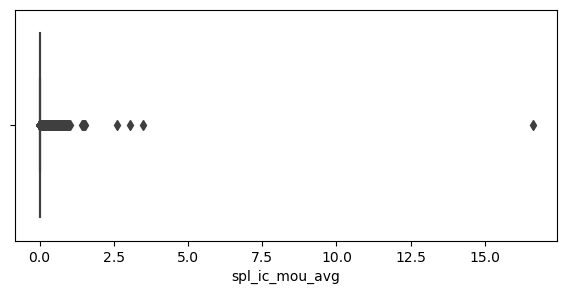

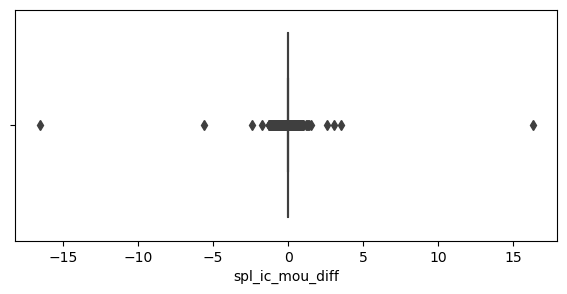

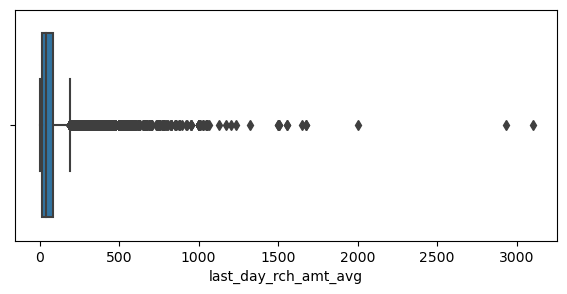

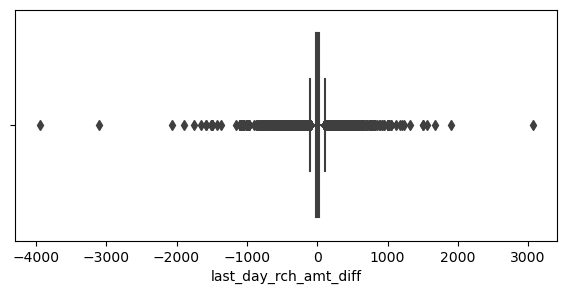

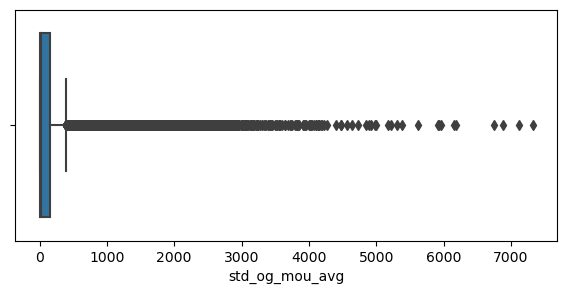

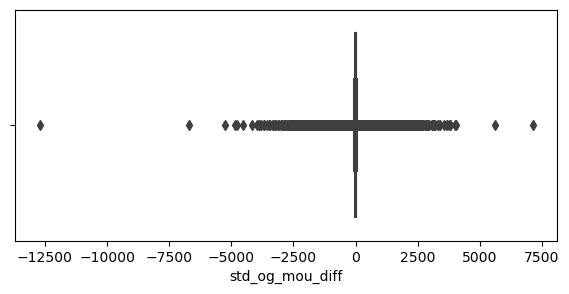

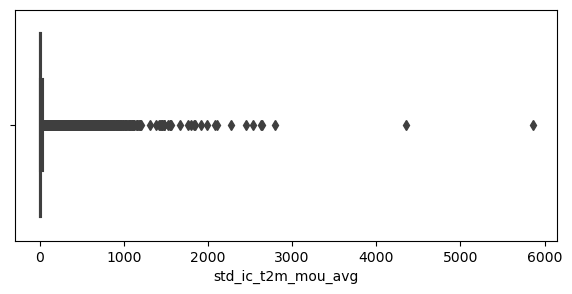

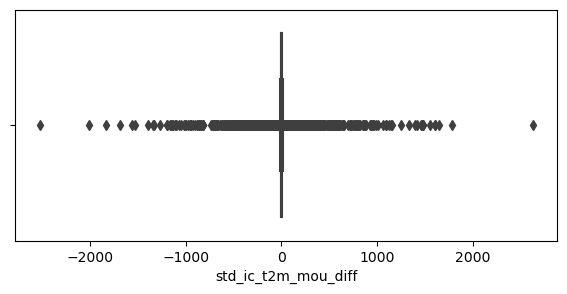

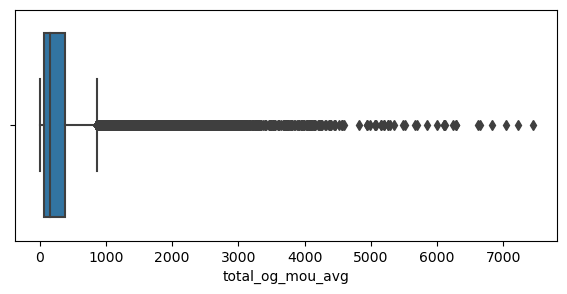

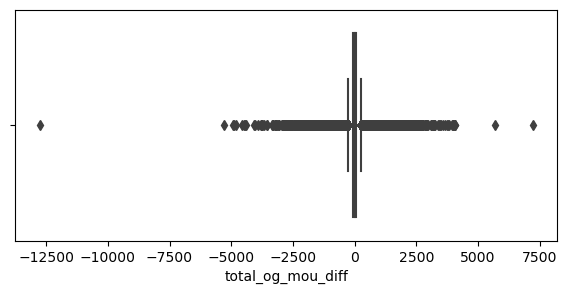

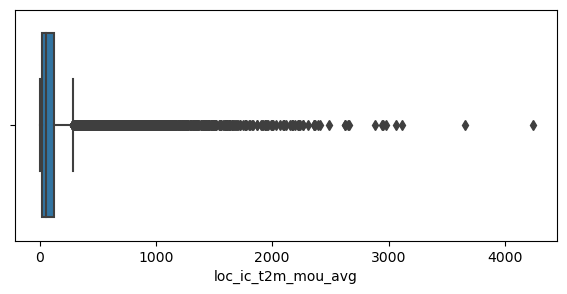

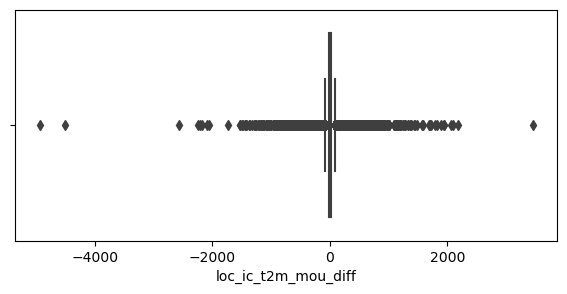

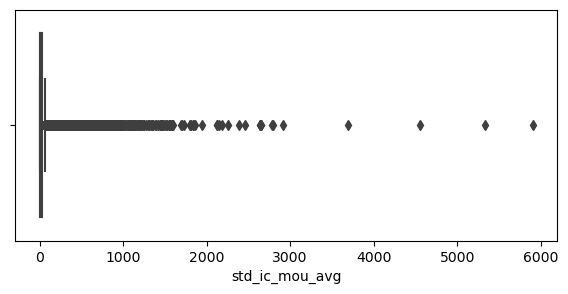

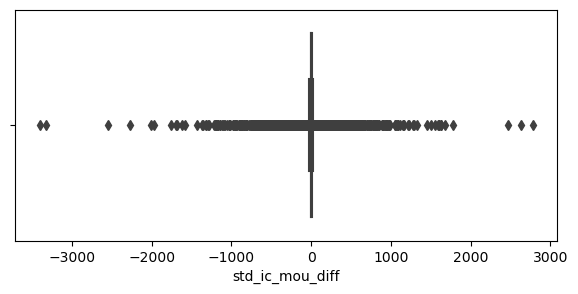

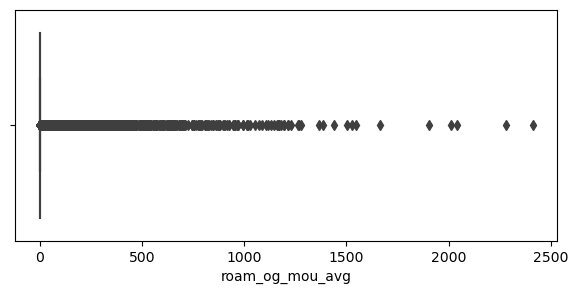

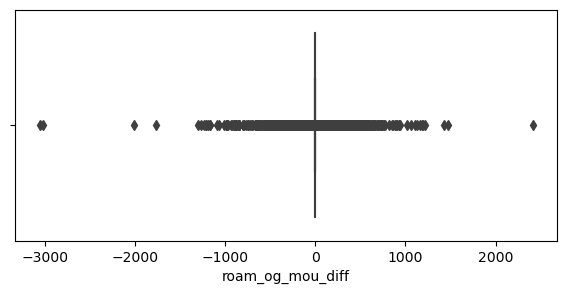

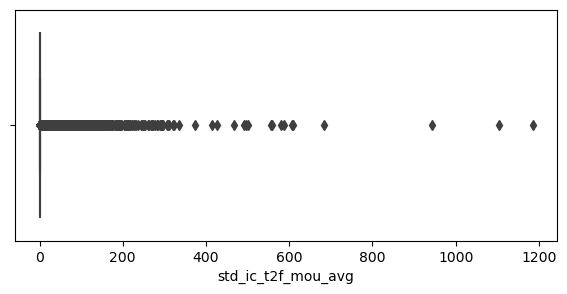

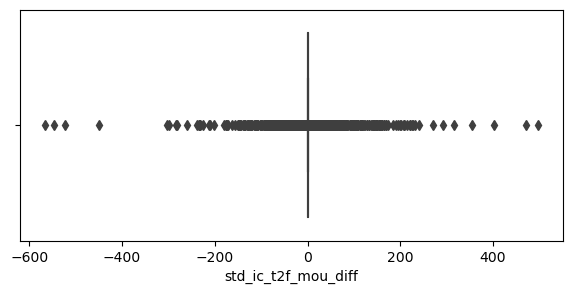

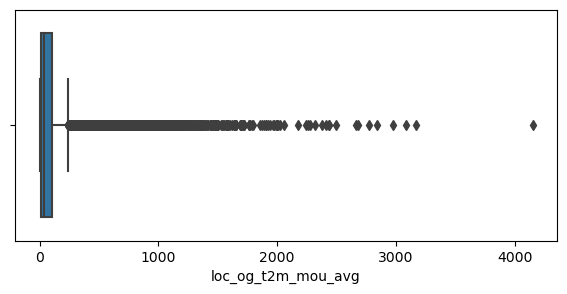

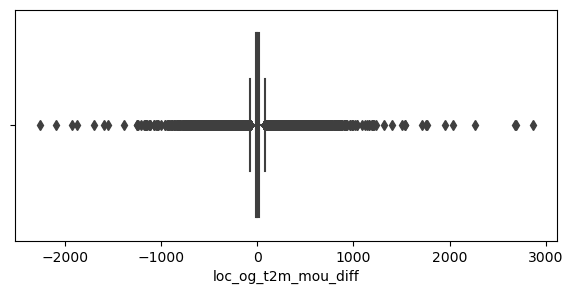

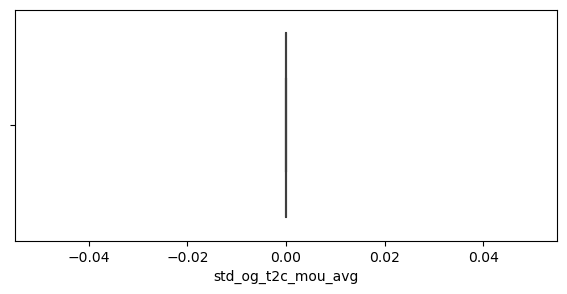

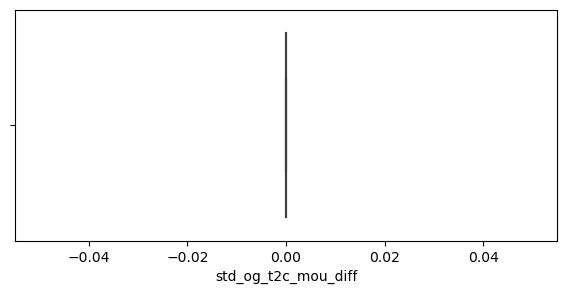

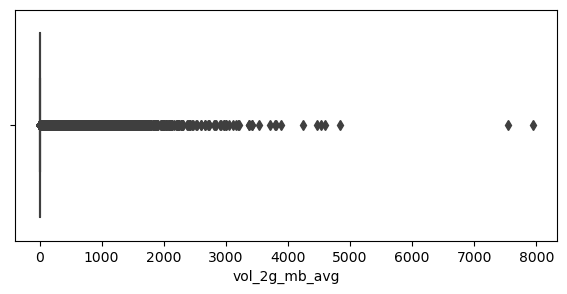

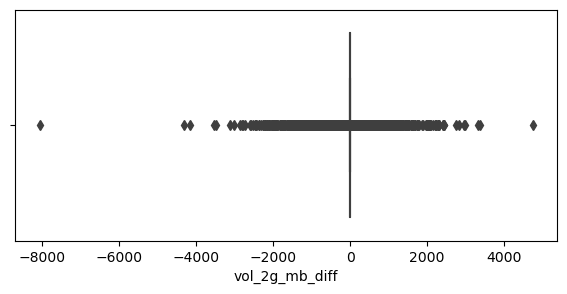

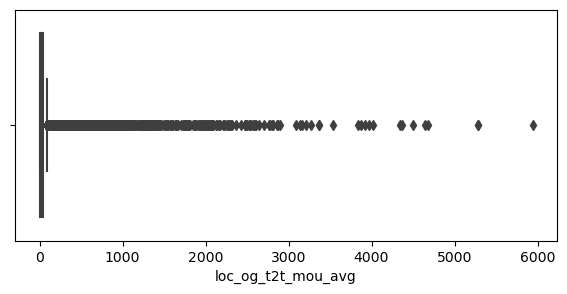

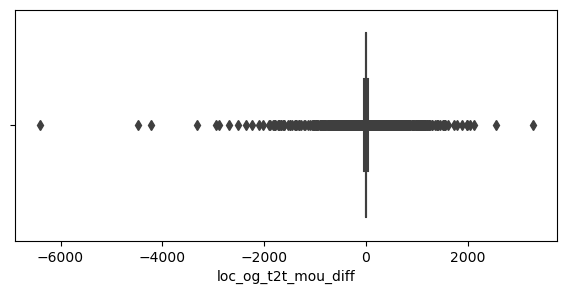

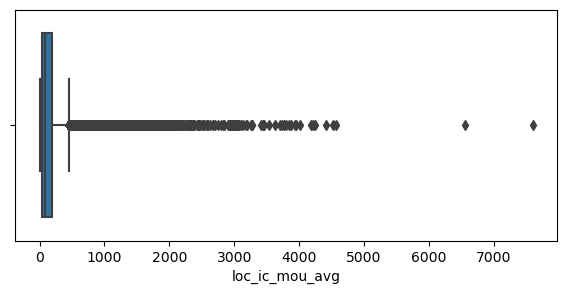

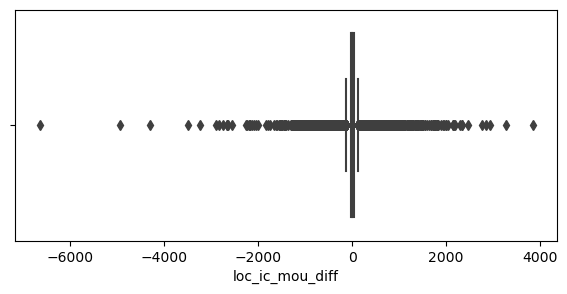

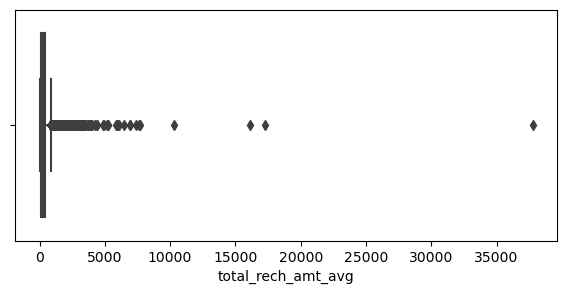

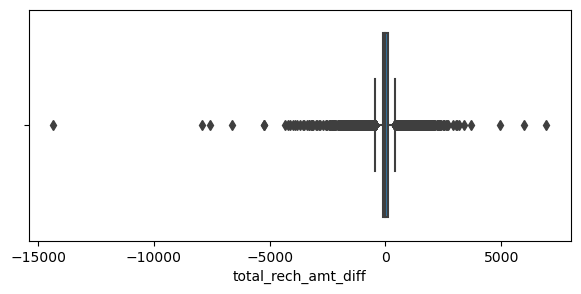

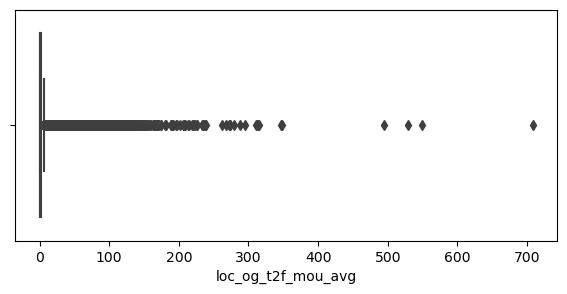

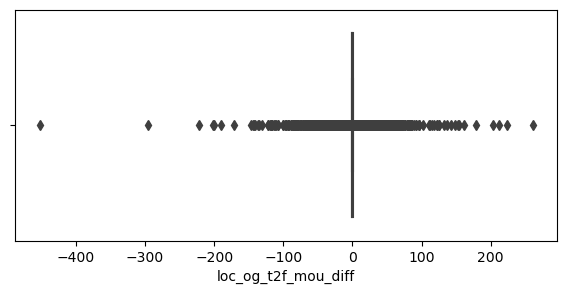

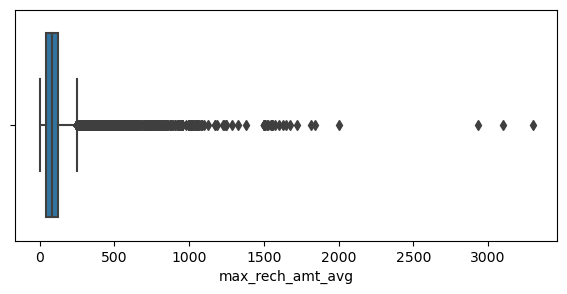

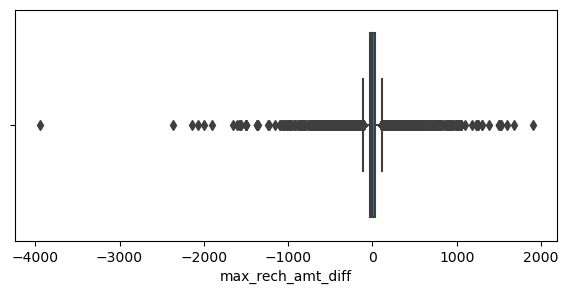

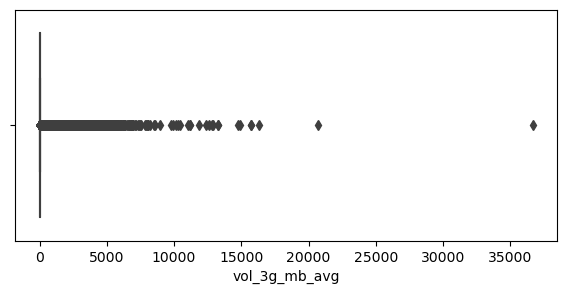

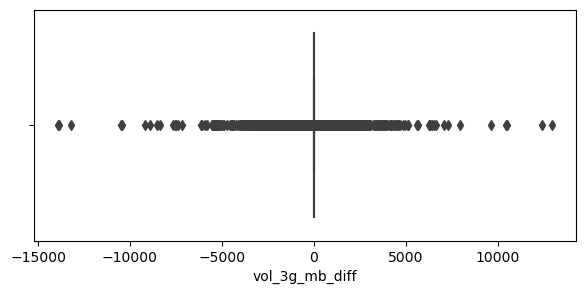

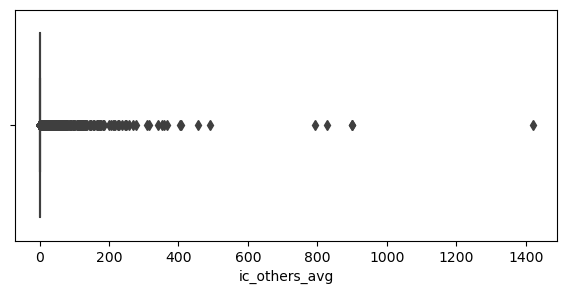

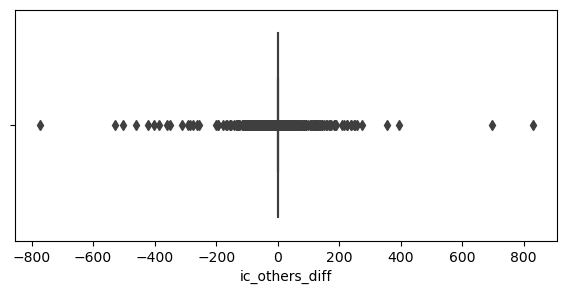

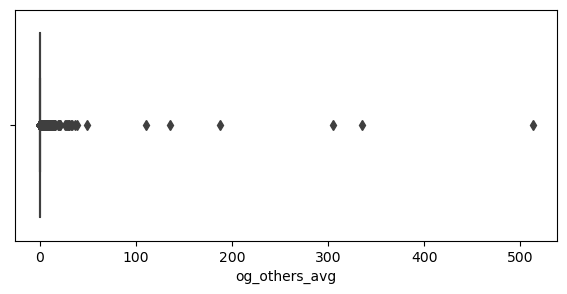

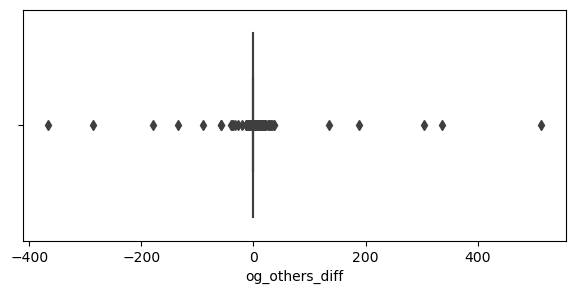

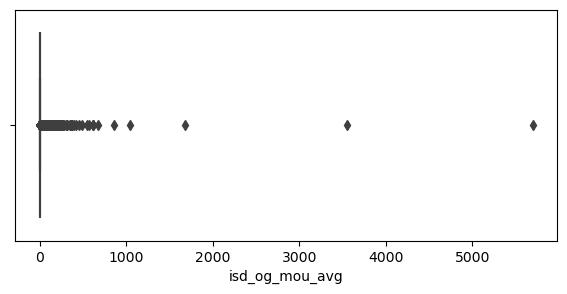

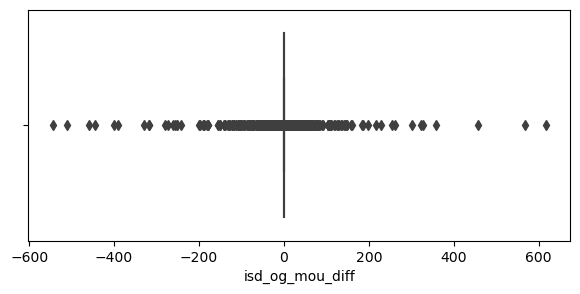

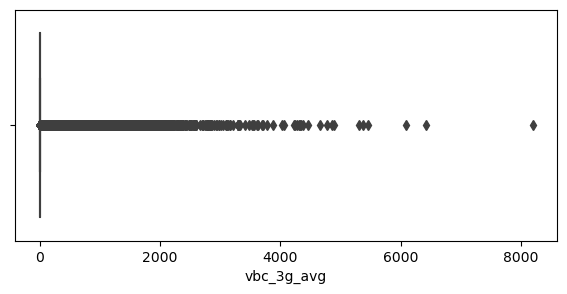

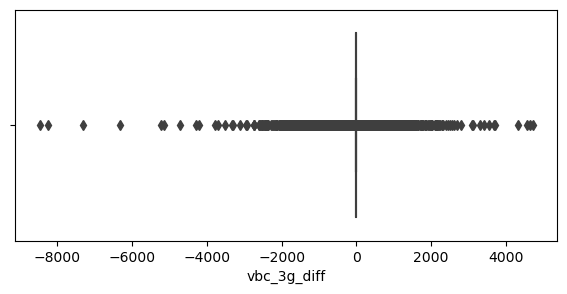

In [15]:
cols_with_std_0 = []
for col in df.columns:
    plt.figure(figsize=(7,3))
    sns.boxplot(x=col, data=df)
    print(col,'std:', df[col].std())
    if df[col].std() == 0:
        cols_with_std_0.append(col)
df.drop(columns=cols_with_std_0, inplace=True)

In [16]:
outlier_columns = ['aon', 'std_og_mou_avg', 'last_day_rch_amt_avg', 'onnet_mou_avg', 'loc_ic_mou_avg', 'loc_og_mou_avg', 'max_rech_amt_avg', 'loc_ic_t2m_mou_avg', 'loc_og_t2m_mou_avg', 'offnet_mou_avg', 'total_rech_num_avg', 'total_ic_mou_avg', 'total_og_mou_avg']
for col in outlier_columns:
    if col != 'churn_probability'  and 'diff' not in col :
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        uqr = df[col].quantile(0.75) + (iqr*1.5)
        lqr = df[col].quantile(0.25) - (iqr*1.5)
        df = df[(df[col] >=lqr) & (df[col] <= uqr)]
        print(col, '-->', df.shape)

aon --> (69938, 85)
std_og_mou_avg --> (60801, 85)
last_day_rch_amt_avg --> (57789, 85)
onnet_mou_avg --> (52222, 85)
loc_ic_mou_avg --> (48719, 85)
loc_og_mou_avg --> (45660, 85)
max_rech_amt_avg --> (44353, 85)
loc_ic_t2m_mou_avg --> (42280, 85)
loc_og_t2m_mou_avg --> (40267, 85)
offnet_mou_avg --> (37902, 85)
total_rech_num_avg --> (35991, 85)
total_ic_mou_avg --> (34670, 85)
total_og_mou_avg --> (34217, 85)


In [17]:
df.iloc[:, :15].describe()

,id,aon,churn_probability,roam_ic_mou_avg,roam_ic_mou_diff,total_ic_mou_avg,total_ic_mou_diff,offnet_mou_avg,offnet_mou_diff,spl_og_mou_avg,spl_og_mou_diff,monthly_2g_avg,monthly_2g_diff,loc_og_mou_avg,loc_og_mou_diff
count,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000,34217.000000
mean,35027.529737,1176.613818,0.115440,5.564626,1.242566,90.931614,-15.537595,59.540928,-22.745209,2.569232,-0.828316,0.081918,-0.002309,51.053047,-9.126190
std,20218.185549,929.867076,0.319556,41.067450,37.613915,79.383116,105.469904,51.075303,134.972218,6.902733,10.642366,0.262677,0.262590,52.349235,73.850447
min,0.000000,180.000000,0.000000,0.000000,-1708.680000,0.000000,-3595.225000,0.000000,-3781.765000,0.000000,-319.875000,0.000000,-3.500000,0.000000,-4330.285000
25%,17487.000000,451.000000,0.000000,0.000000,0.000000,25.235000,-36.980000,18.410000,-30.840000,0.000000,-0.425000,0.000000,0.000000,7.845000,-21.585000
50%,35030.000000,828.000000,0.000000,0.000000,0.000000,72.065000,0.000000,47.560000,0.000000,0.040000,0.000000,0.000000,0.000000,35.100000,0.000000
75%,52703.000000,1706.000000,0.000000,0.000000,0.000000,138.510000,25.325000,89.225000,22.395000,2.240000,0.575000,0.000000,0.000000,79.060000,15.780000
max,69998.000000,3821.000000,1.000000,2773.195000,1425.490000,332.760000,332.030000,235.200000,235.200000,226.965000,202.960000,4.500000,2.500000,275.935000,263.460000


### Bivariate Analysis

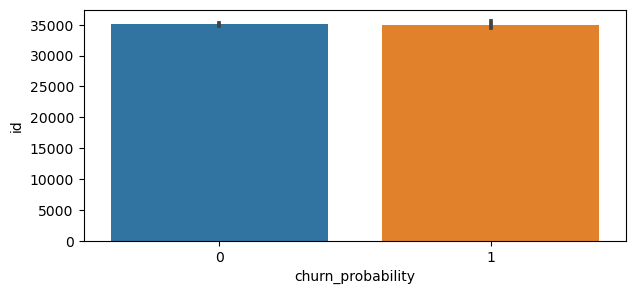

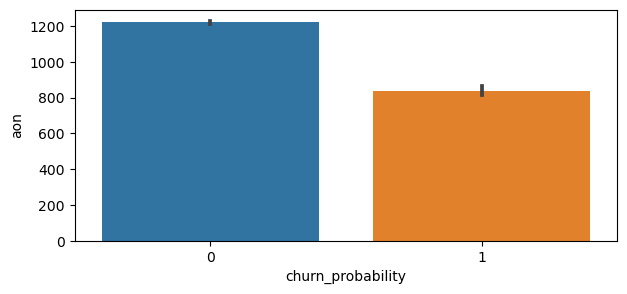

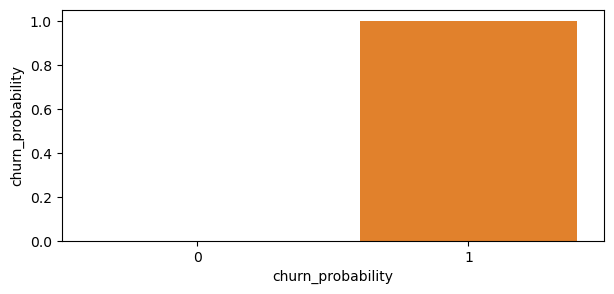

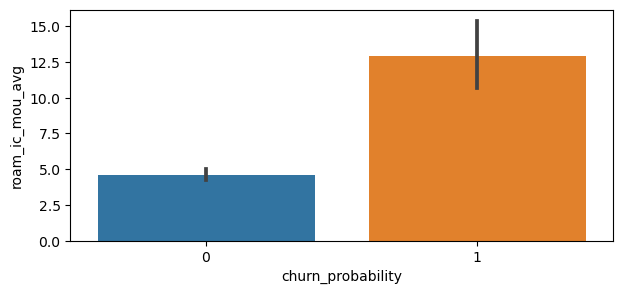

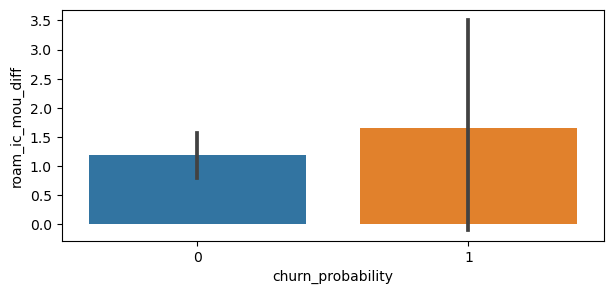

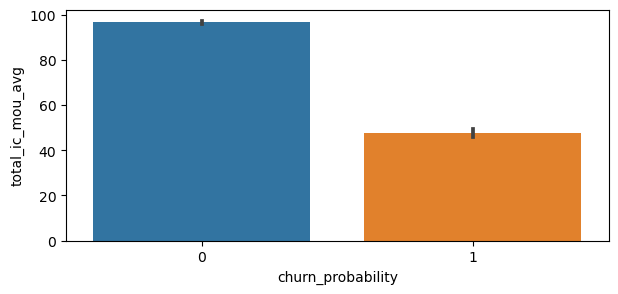

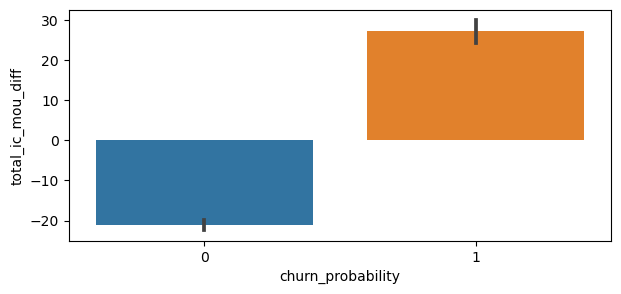

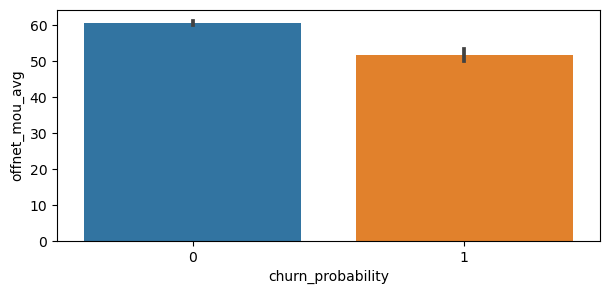

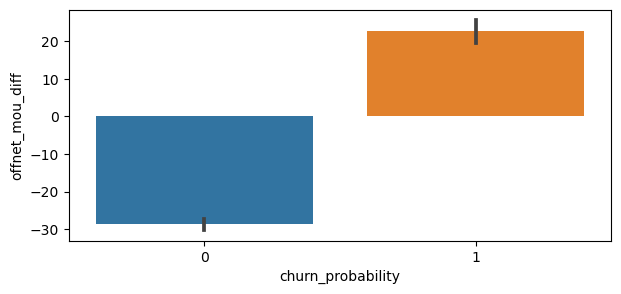

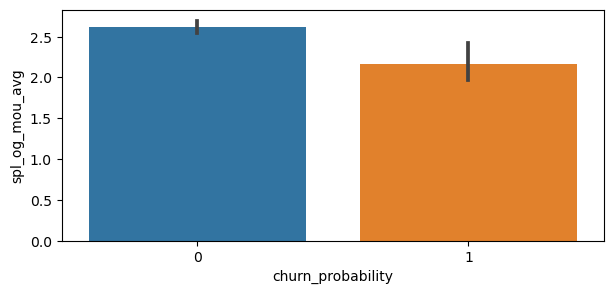

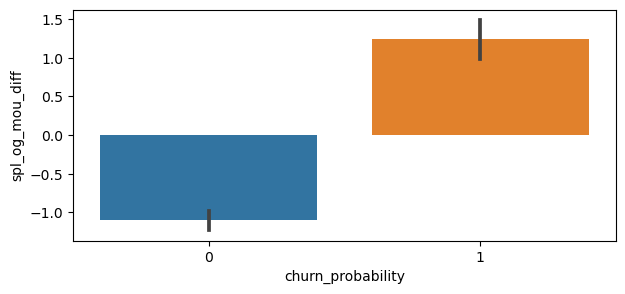

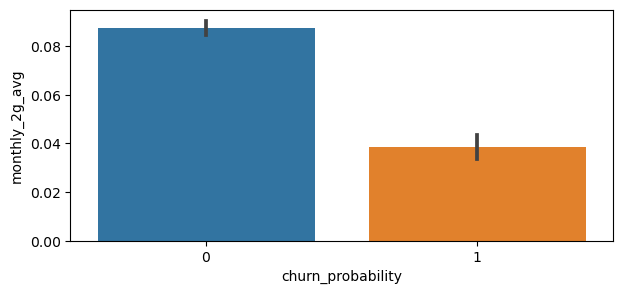

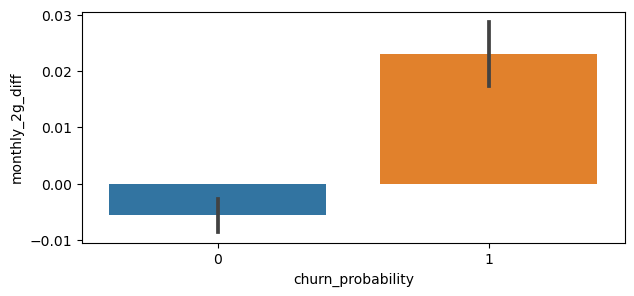

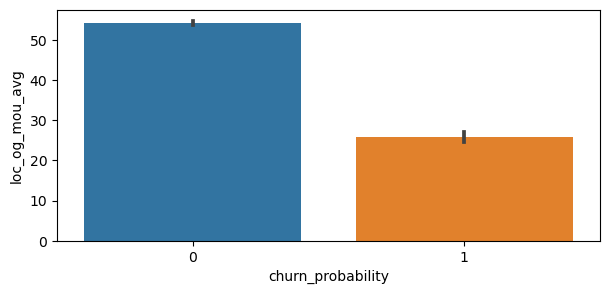

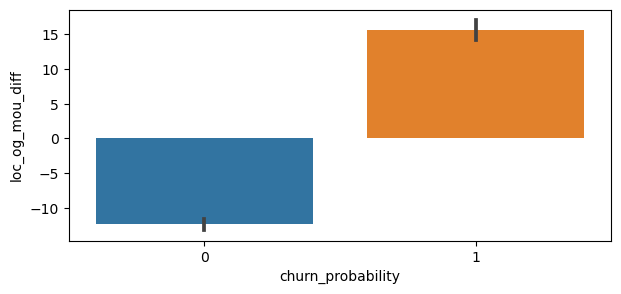

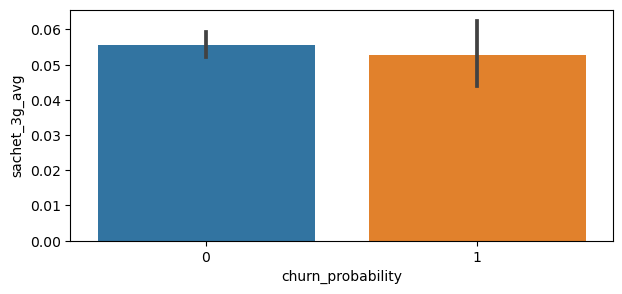

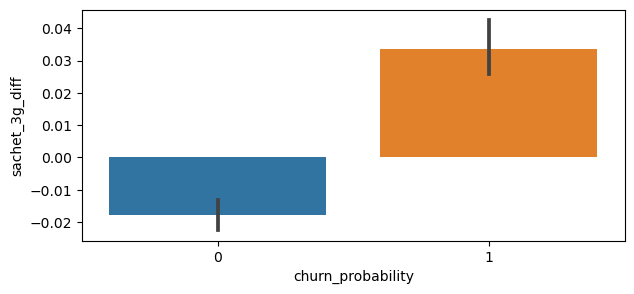

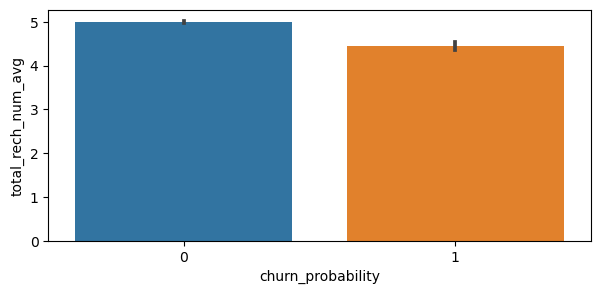

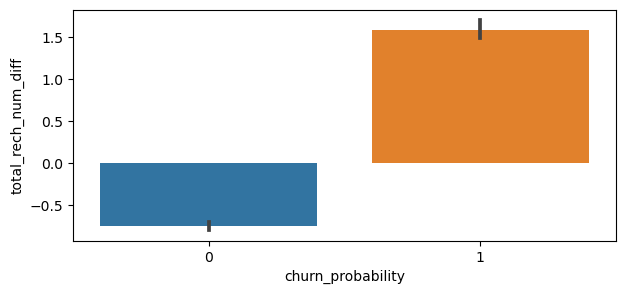

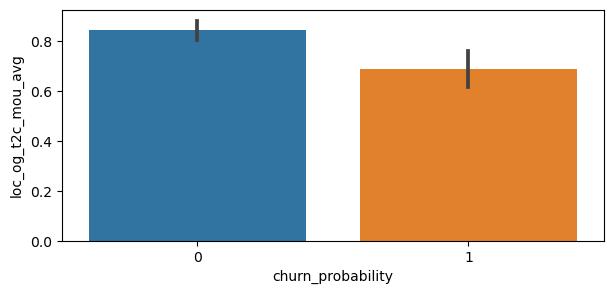

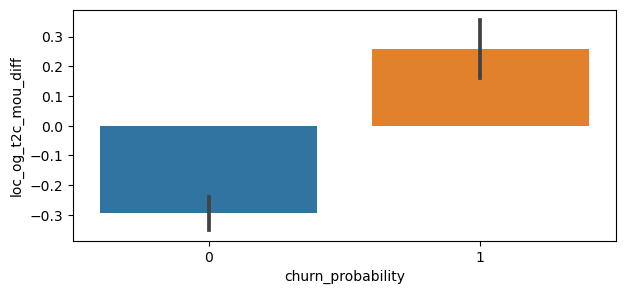

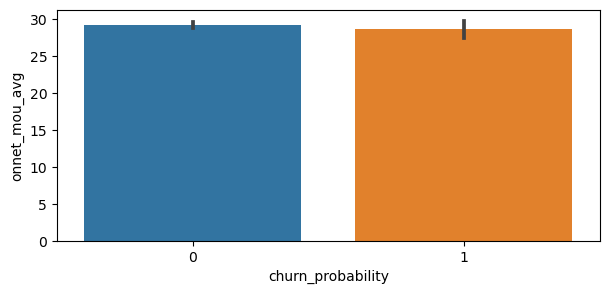

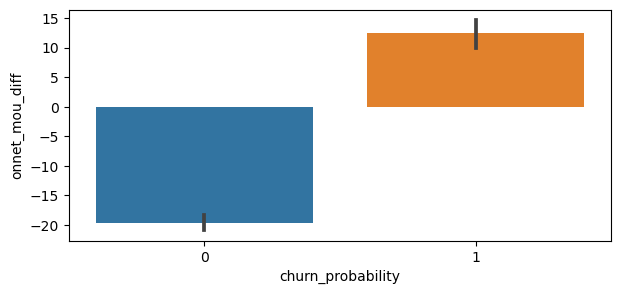

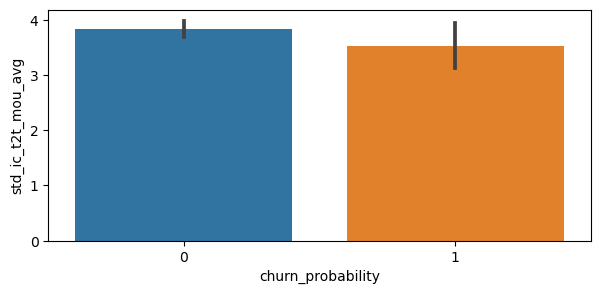

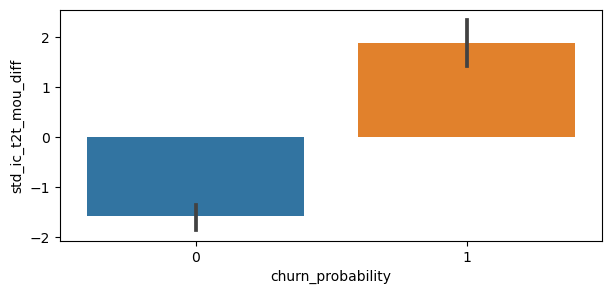

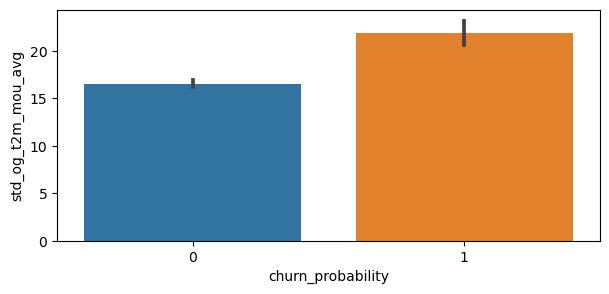

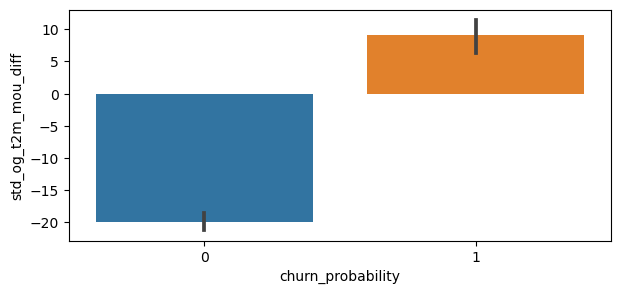

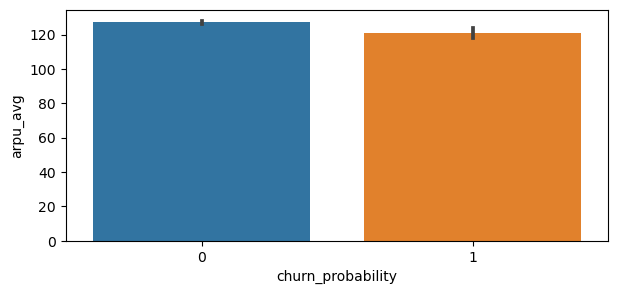

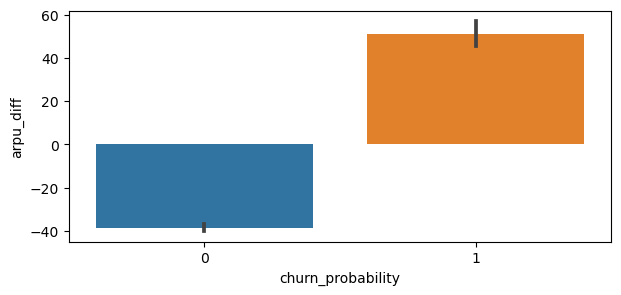

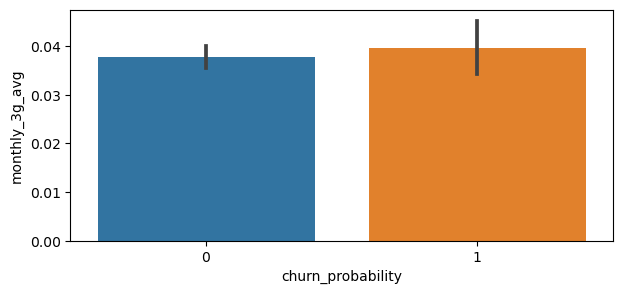

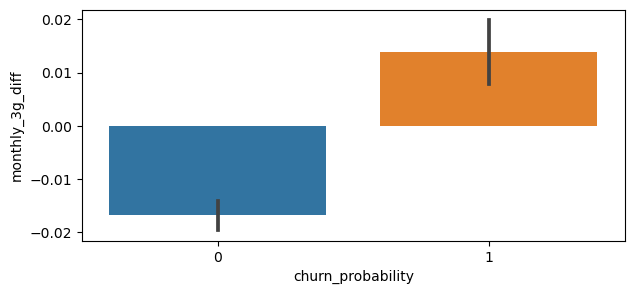

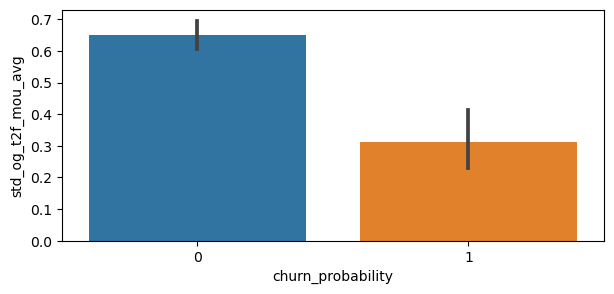

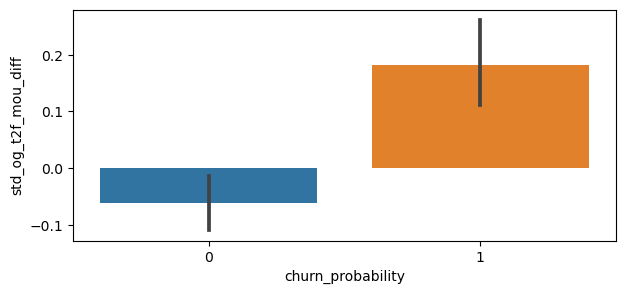

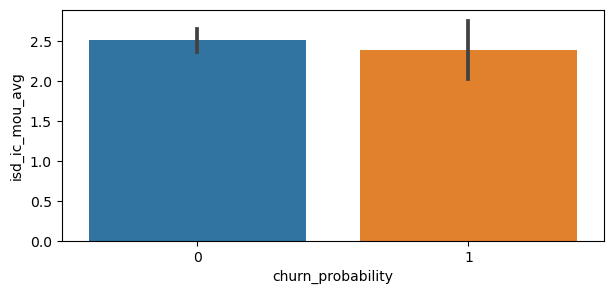

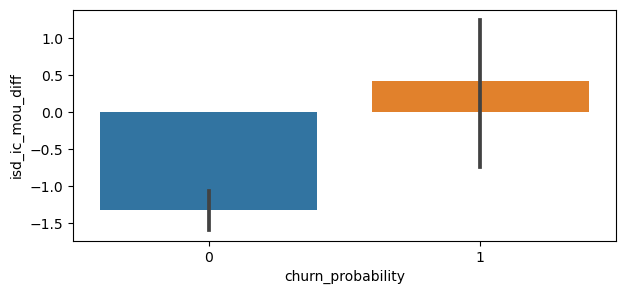

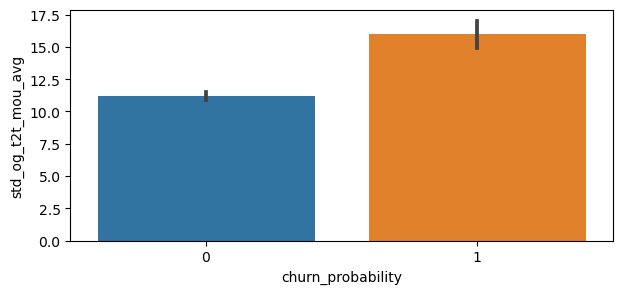

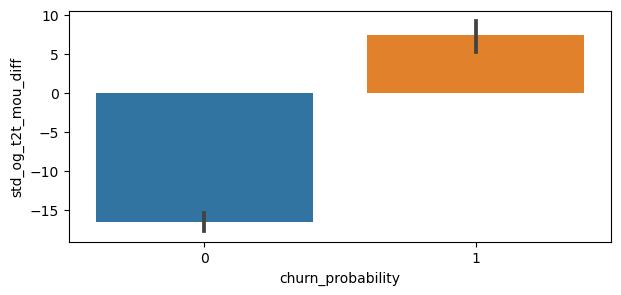

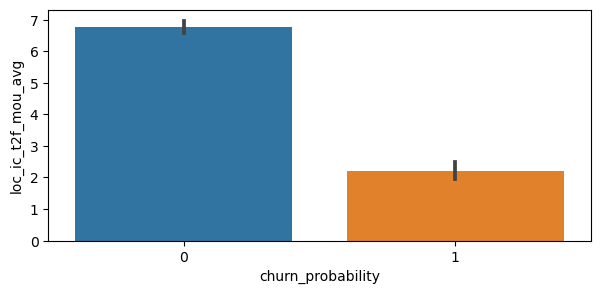

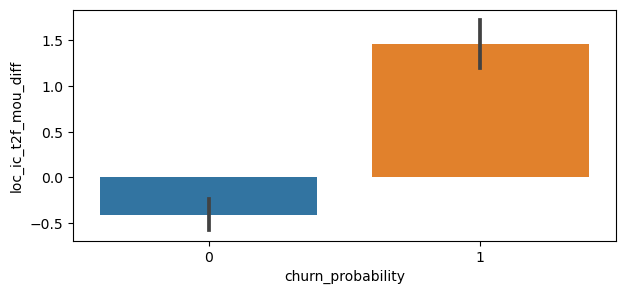

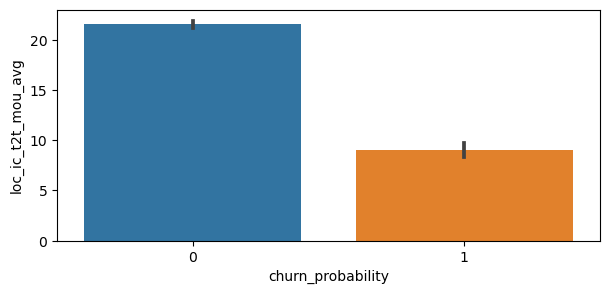

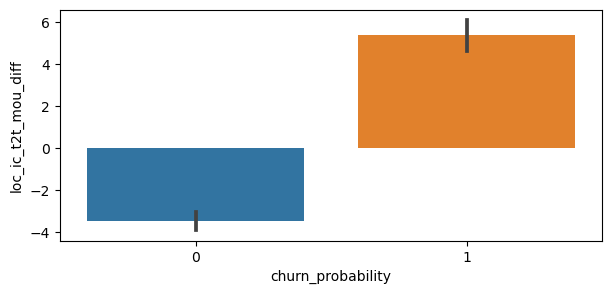

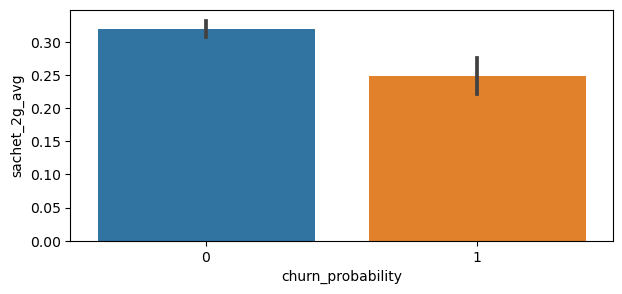

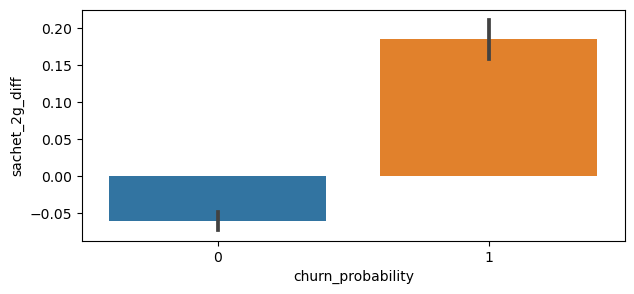

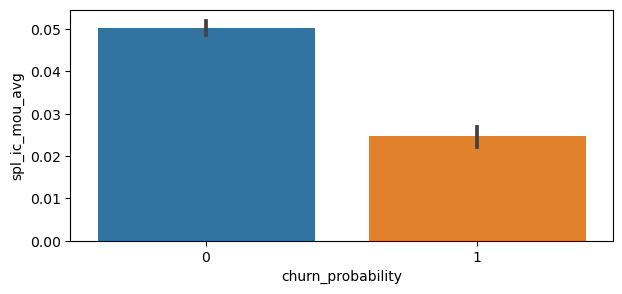

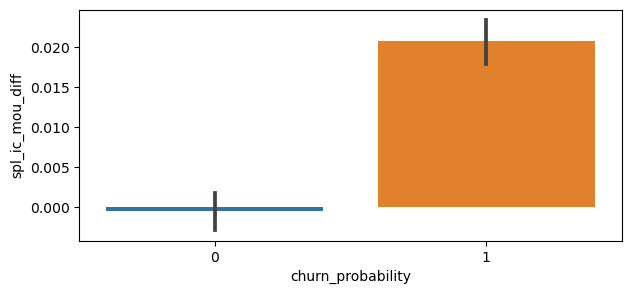

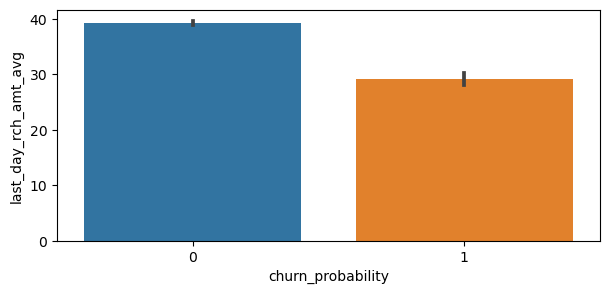

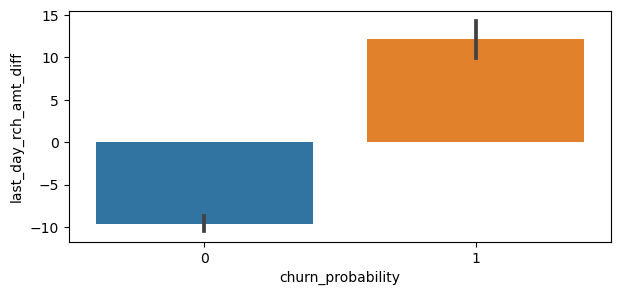

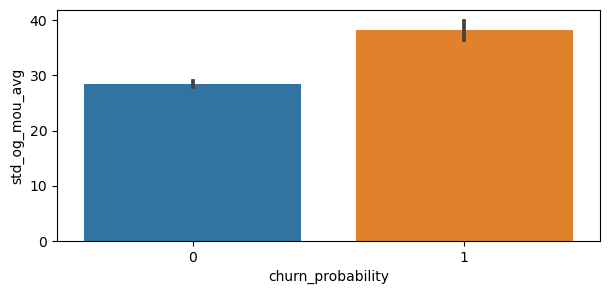

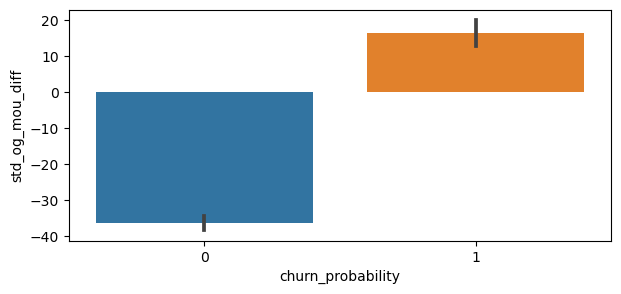

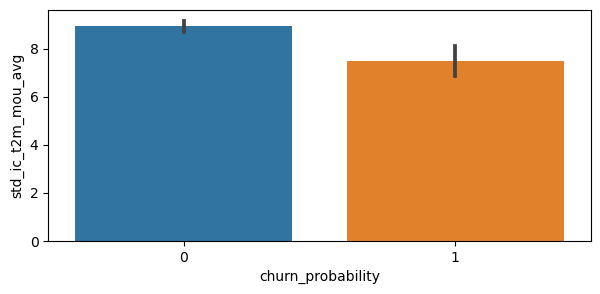

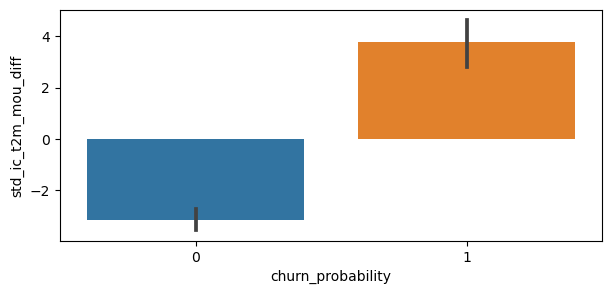

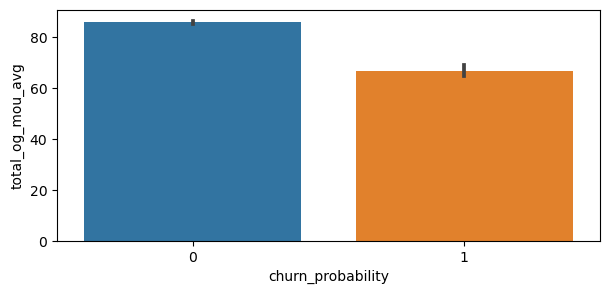

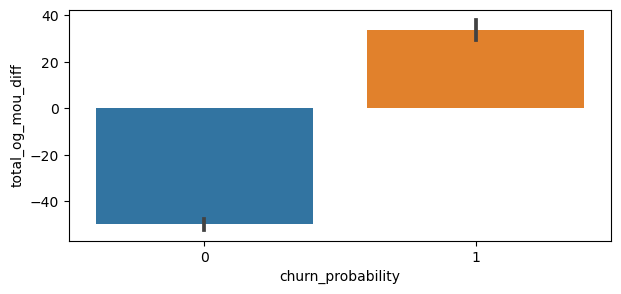

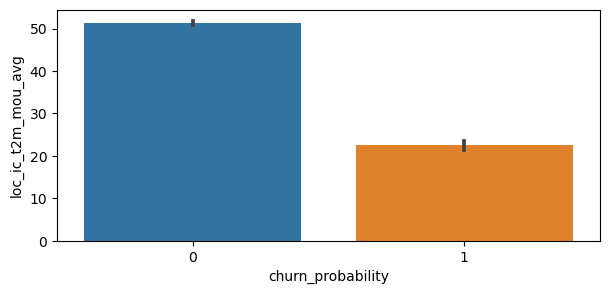

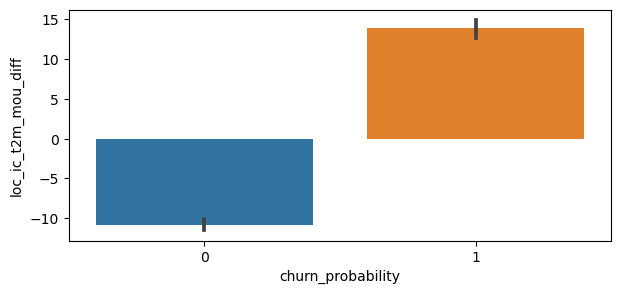

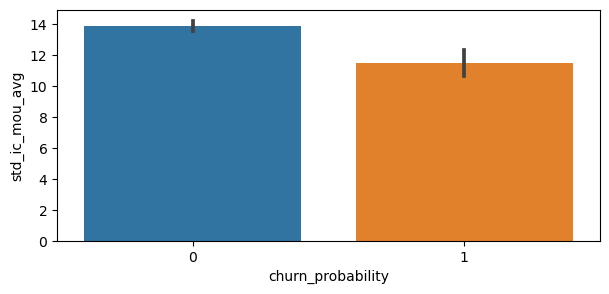

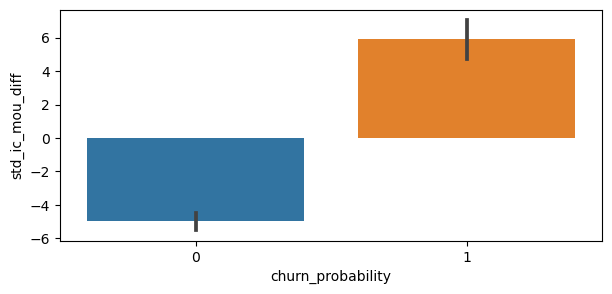

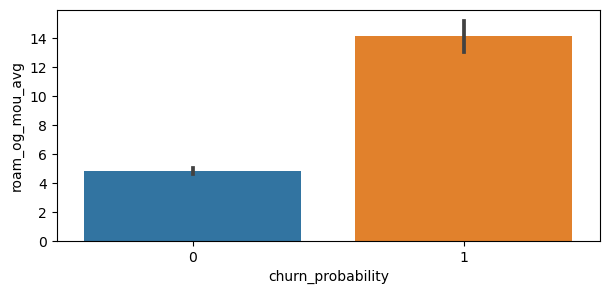

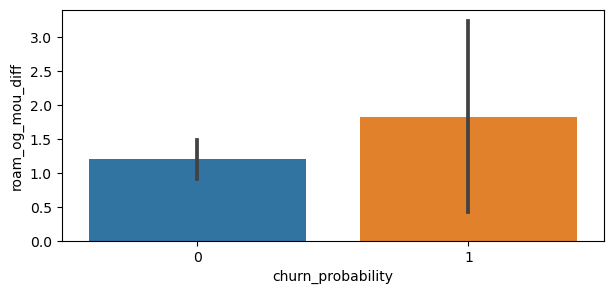

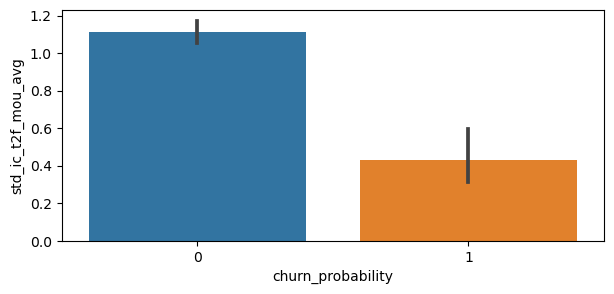

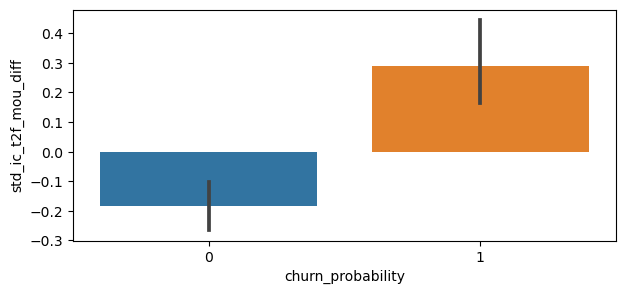

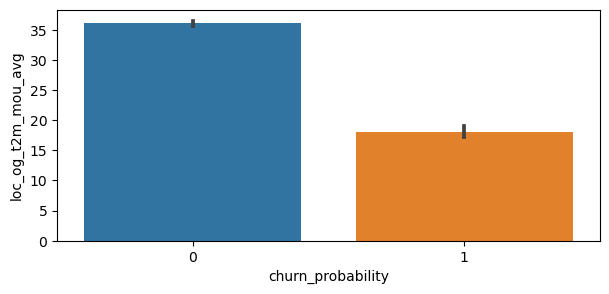

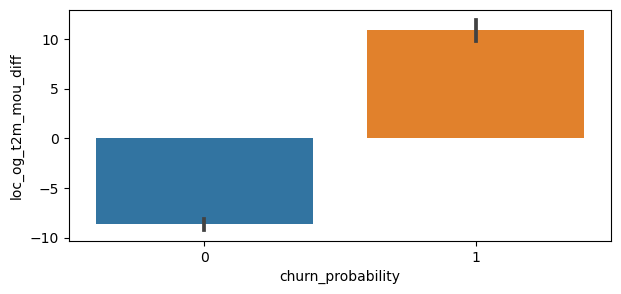

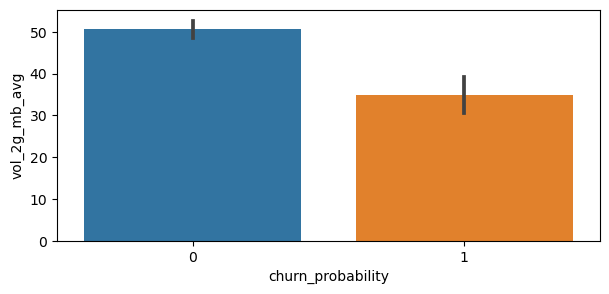

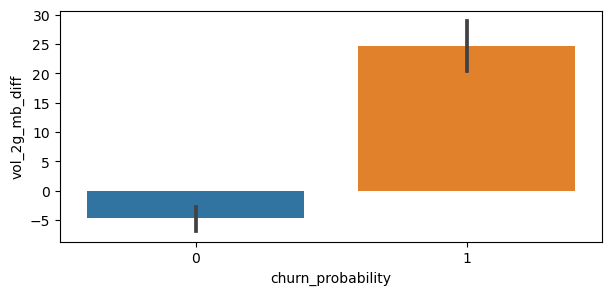

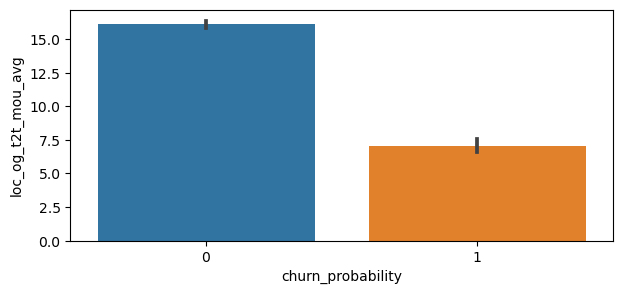

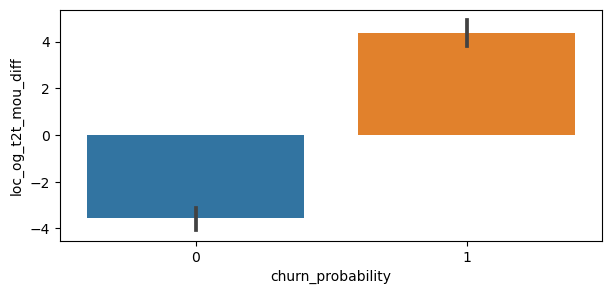

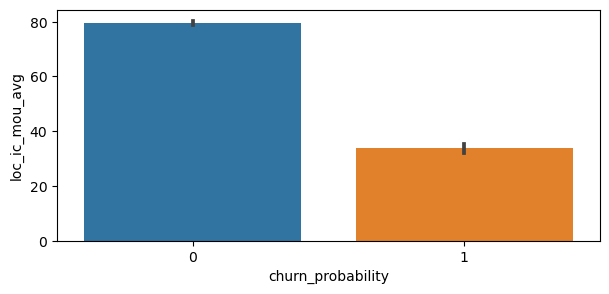

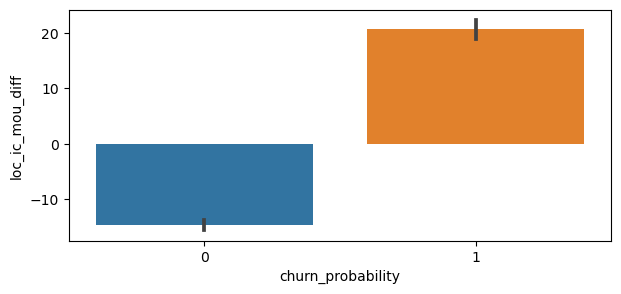

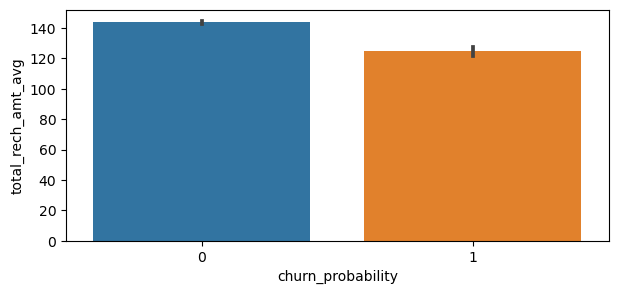

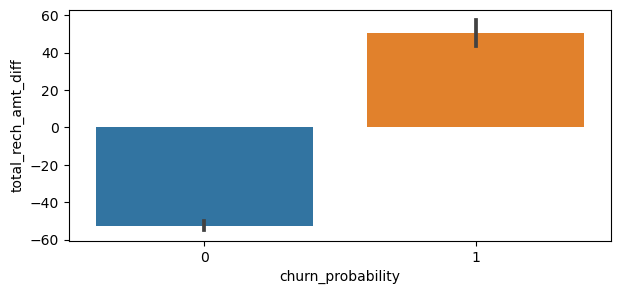

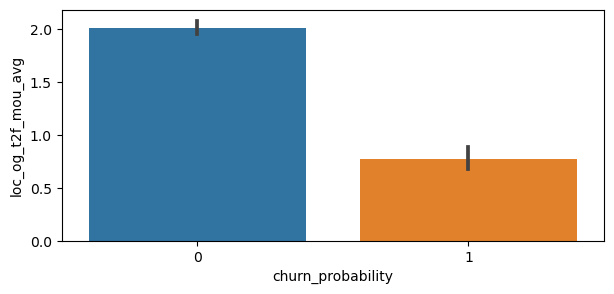

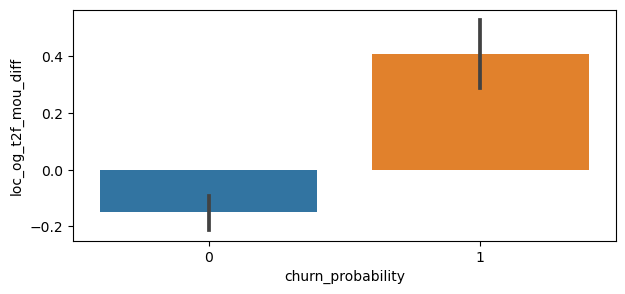

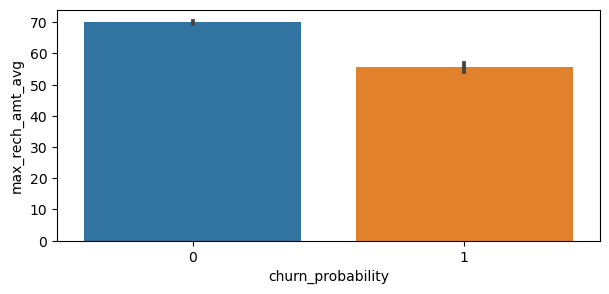

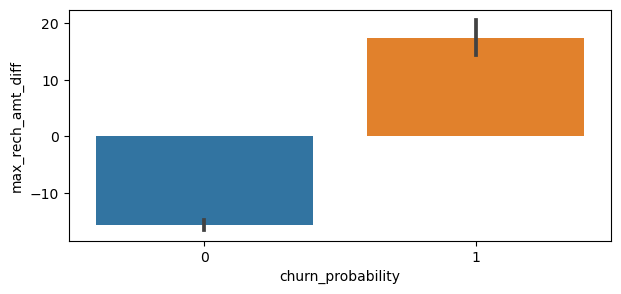

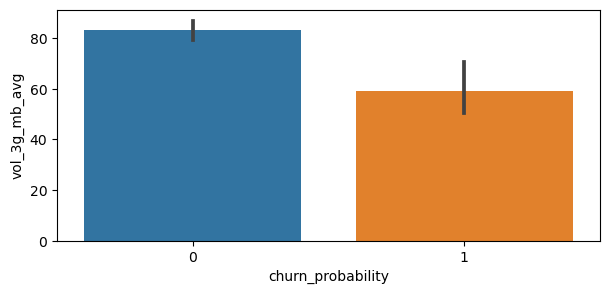

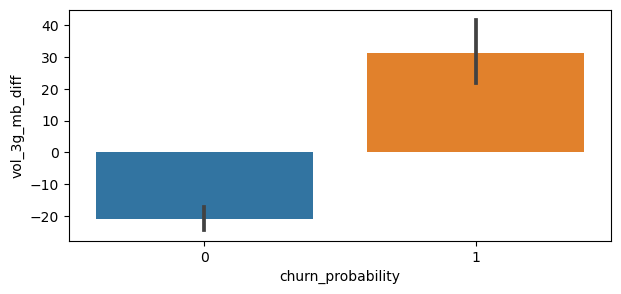

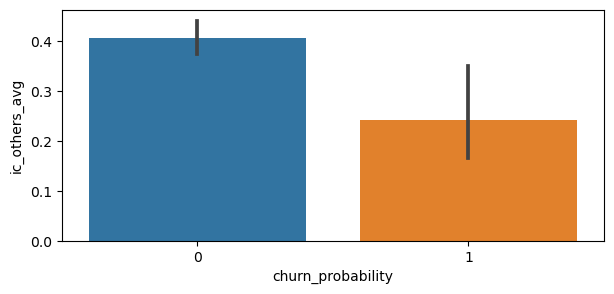

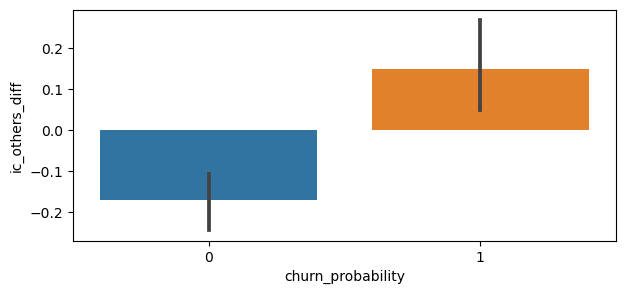

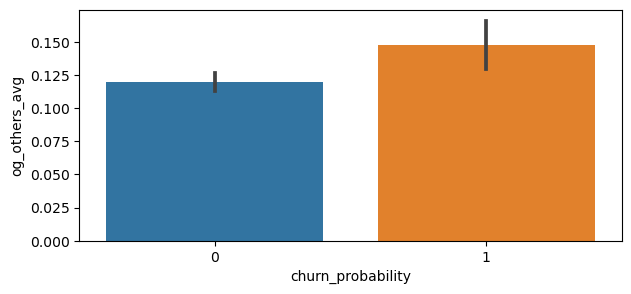

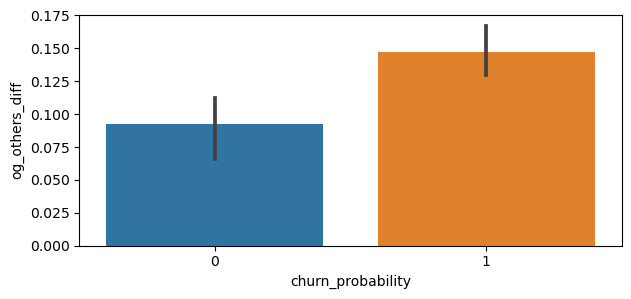

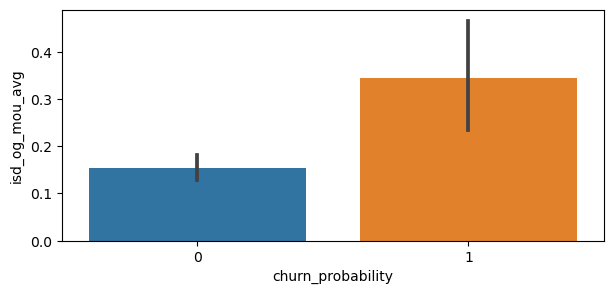

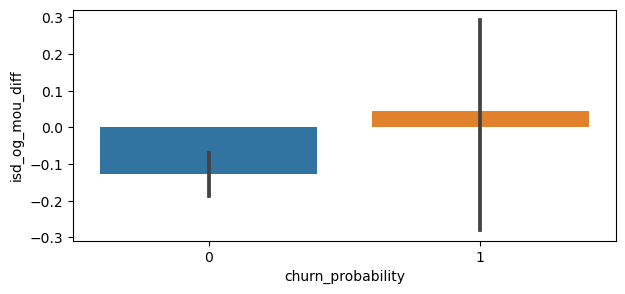

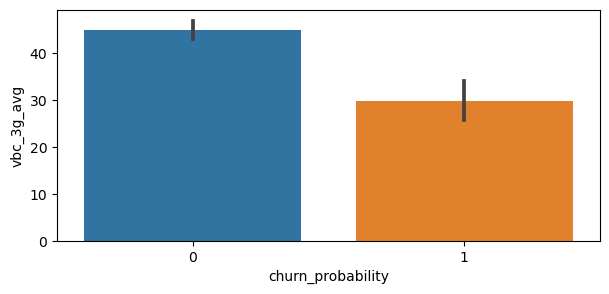

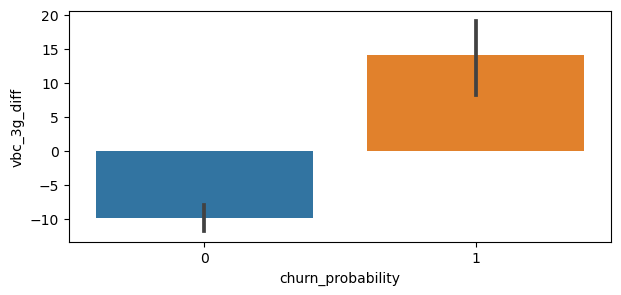

In [18]:
for col in df.columns:
    plt.figure(figsize=(7,3))
    sns.barplot(x='churn_probability',y=col, data=df)

#### From Above chart we understood
1. Newer customers are very likely churn compared to older customers. Newer customer's average age around 800days
2. We can see non churn customer usaage are high compared churn.
3. Difference between avg usage and last month usage is high for churned customers

### Handling Imbalance Data

<AxesSubplot:xlabel='churn_probability', ylabel='count'>

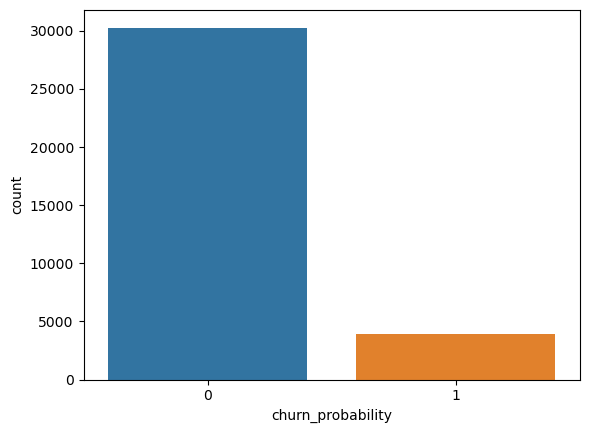

In [19]:
sns.countplot(x='churn_probability', data=df)

In [20]:
df['churn_probability'].value_counts()

0    30267
1     3950
Name: churn_probability, dtype: int64

In [25]:
new_df = df.copy()

In [26]:
y = new_df.loc[:, ['churn_probability']]
new_df.drop(columns=['churn_probability'], inplace=True)

In [27]:
smote = SMOTE(random_state = 2)
new_df, y = smote.fit_resample(new_df, y)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y, random_state=42, test_size=0.2)

### Feature Importance

#### Logistic Regression Feature Importance

In [31]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                48427
Model:                            GLM   Df Residuals:                    48342
Model Family:                Binomial   Df Model:                           84
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16243.
Date:                Mon, 12 Dec 2022   Deviance:                       32487.
Time:                        23:57:03   Pearson chi2:                 5.17e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.5110
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.2687      0.058     56.249      0.000       3.155       3.383
id                     1.901e-07   7.06e-07      0.269      0.788   -1.19e-06    1.57e-06
aon                      -0.0003    1.9e-05    -13.429      0.000      -0.000      -0.000
roam_ic_mou_avg           0.0005      0.000      0.985      0.325      -0.000       0.001
roam_ic_mou_diff          0.0007      0.000      1.504      0.133      -0.000       0.002
total_ic_mou_avg        -92.1737      5.110    -18.037      0.000    -102.190     -82.158
total_ic_mou_diff        83.0267      3.470     23.925      0.000      76.225      89.828
offnet_mou_avg           -0.0129      0.008     -1.633      0.103      -0.028       0.003
offnet_mou_diff           0.0109      0.004      2.536      0.011       0.002       0.019
spl_og_mou_avg           18.3846      4.950      3.714      0.000       8.683      28.087
spl_og_mou_diff         -19.9709      3.346     -5.968      0.000     -26.530     -13.412
monthly_2g_avg           -1.6647      0.133    -12.493      0.000      -1.926      -1.404
monthly_2g_diff           0.9260      0.105      8.812      0.000       0.720       1.132
loc_og_mou_avg          -83.0692      7.178    -11.573      0.000     -97.138     -69.001
loc_og_mou_diff          33.9879      4.735      7.178      0.000      24.708      43.268
sachet_3g_avg            -0.3161      0.061     -5.147      0.000      -0.436      -0.196
sachet_3g_diff            0.3410      0.069      4.962      0.000       0.206       0.476
total_rech_num_avg       -0.1881      0.010    -17.959      0.000      -0.209      -0.168
total_rech_num_diff       0.1726      0.008     22.859      0.000       0.158       0.187
loc_og_t2c_mou_avg       -0.0088      0.007     -1.235      0.217      -0.023       0.005
loc_og_t2c_mou_diff      -0.0220      0.005     -4.410      0.000      -0.032      -0.012
onnet_mou_avg            -0.0150      0.008     -1.797      0.072      -0.031       0.001
onnet_mou_diff            0.0097      0.005      2.017      0.044       0.000       0.019
std_ic_t2t_mou_avg       -9.8861      8.349     -1.184      0.236     -26.250       6.477
std_ic_t2t_mou_diff     -29.8125      5.723     -5.209      0.000     -41.030     -18.595
std_og_t2m_mou_avg      -15.8681      8.137     -1.950      0.051     -31.815       0.079
std_og_t2m_mou_diff      -0.5860      5.314     -0.110      0.912     -11.001       9.829
arpu_avg                  0.0072      0.001     10.416      0.000       0.006       0.009
arpu_diff                -0.0031      0.000     -8.331      0.000      -0.004      -0.002
monthly_3g_avg           -0.5399      0.125     -4.311      0.000      -0.785      -0.294
monthly_3g_diff           0.3685      0.104      3.558      0.000       0.166       0.571
std_og_t2f_mou_avg     

In [32]:
y_pred = res.predict(sm.add_constant(X_test)).values.reshape(-1)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]

In [33]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8661105145783431
ROC AUC: 0.8658082695684075
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      5952
           1       0.86      0.88      0.87      6155

    accuracy                           0.87     12107
   macro avg       0.87      0.87      0.87     12107
weighted avg       0.87      0.87      0.87     12107



#### XGB Classifier

In [34]:
xgbm = XGBClassifier()
xgbm_model = xgbm.fit(X_train, y_train)

In [35]:
fi = pd.DataFrame({
    'features':list(new_df.columns),
    'importance':list(xgbm_model.feature_importances_)}
)
fi.sort_values(ascending=False, by='importance')

,features,importance
27,arpu_diff,0.099302
66,loc_ic_mou_avg,0.065850
57,roam_og_mou_diff,0.056372
67,loc_ic_mou_diff,0.053923
5,total_ic_mou_diff,0.047632
...,...,...
6,offnet_mou_avg,0.002100
70,loc_og_t2f_mou_avg,0.002002
60,loc_og_t2m_mou_avg,0.001962
30,std_og_t2f_mou_avg,0.001897


In [36]:
y_pred = xgbm_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9536631700669035
ROC AUC: 0.9536404422490674
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5952
           1       0.95      0.95      0.95      6155

    accuracy                           0.95     12107
   macro avg       0.95      0.95      0.95     12107
weighted avg       0.95      0.95      0.95     12107



In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Apply PCA

In [38]:
pca = PCA(random_state=42)
pca.fit(X_train_scaled)

PCA(random_state=42)

In [39]:
pca.components_

array([[-1.88844247e-03, -2.69152893e-02,  1.25729129e-03, ...,
        -5.21837163e-02, -2.74735613e-02, -3.82471792e-02],
       [-8.78690902e-07,  1.17448579e-01, -1.40142849e-02, ...,
        -3.53608296e-02,  3.49963478e-02, -2.48107100e-02],
       [ 5.04109025e-03,  5.34226280e-02,  1.28089129e-02, ...,
         3.46932476e-02,  2.58315601e-01,  1.20232460e-01],
       ...,
       [-1.33780715e-07, -1.27438895e-06, -5.44374817e-08, ...,
        -1.09280335e-02, -5.91943413e-07,  3.15856754e-07],
       [ 3.70877385e-08,  8.24252214e-07, -7.92604468e-08, ...,
         2.43615162e-02,  3.86874448e-07, -1.85698902e-07],
       [-7.44787165e-08, -1.97924991e-07,  2.86956599e-08, ...,
        -9.07526312e-03,  1.76513129e-07, -2.47855860e-07]])

In [40]:
sorted(pca.explained_variance_ratio_)

[1.7486959392122456e-12,
 5.400148319083138e-12,
 7.135719029150582e-12,
 1.1105140418250015e-11,
 1.4728290528170032e-11,
 2.1799886782226232e-11,
 2.4829371786129182e-11,
 2.7852503646333543e-11,
 4.3341369078765835e-11,
 6.08102493325429e-11,
 7.249650465654882e-11,
 1.0845670465444332e-10,
 3.901479575237637e-06,
 9.518874593876751e-06,
 8.60060440956064e-05,
 0.00031349626181126177,
 0.0003821121530414297,
 0.0012784102654522667,
 0.0013253723743469538,
 0.0018454968069054514,
 0.00217738658863837,
 0.002895907268120788,
 0.003091113196414592,
 0.0034028952789887574,
 0.003513592452686543,
 0.003938019238786889,
 0.004462700401071562,
 0.0045824882299989,
 0.004711564776593229,
 0.005139092251663337,
 0.005445454769700256,
 0.005728331666761237,
 0.006058765624346075,
 0.006332219545446348,
 0.006453937998210799,
 0.006632830318530279,
 0.006692119878868495,
 0.006878247871771482,
 0.006943649594023831,
 0.007293751632341368,
 0.007617383994061304,
 0.008049948982734735,
 0.008391

Text(0, 0.5, 'Cumulative variance')

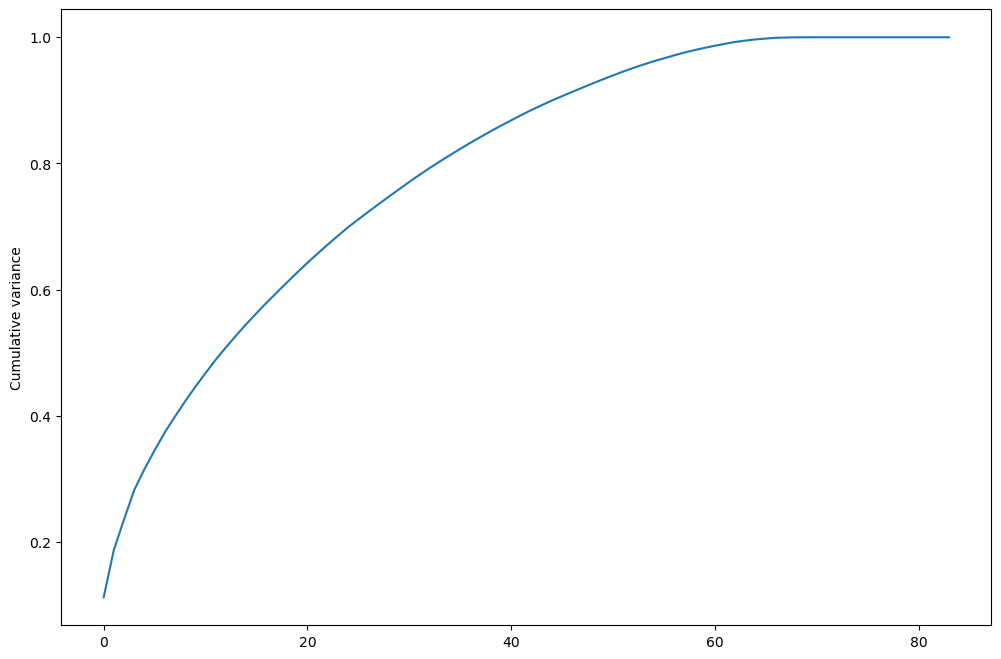

In [41]:
var_cum = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[12,8])
plt.plot(var_cum)
plt.ylabel('Cumulative variance')

In [42]:
#Perform PCA using 55 features

In [43]:
from sklearn.decomposition import IncrementalPCA

In [44]:
inc_pca = IncrementalPCA(n_components=55)
pca_train_df = inc_pca.fit_transform(X_train)
pca_test_df = inc_pca.transform(X_test)
print(pca_train_df.shape, pca_test_df.shape)

(48427, 55) (12107, 55)


In [45]:
cormat = np.corrcoef(pca_train_df.transpose())

### Prediction

#### Logistic Regression

In [46]:
log_reg = LogisticRegression()
log_model = log_reg.fit(pca_train_df, y_train)
y_pred = log_model.predict(pca_test_df)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.8059800115635583
ROC AUC: 0.8039347681533503


In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.68      0.78      5952
           1       0.75      0.93      0.83      6155

    accuracy                           0.81     12107
   macro avg       0.82      0.80      0.80     12107
weighted avg       0.82      0.81      0.80     12107



#### XGBoost Classification

In [48]:
xgb_cl = XGBClassifier()
xgb_model_cl = xgb_cl.fit(pca_train_df, y_train)
y_pred = xgb_model_cl.predict(pca_test_df)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.9162467993722639
ROC AUC: 0.915827049649293


In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      5952
           1       0.90      0.94      0.92      6155

    accuracy                           0.92     12107
   macro avg       0.92      0.92      0.92     12107
weighted avg       0.92      0.92      0.92     12107



# Random Forest Classifier

In [50]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3)
rf_cl = rf.fit(pca_train_df, y_train)
y_pred =rf.predict(pca_test_df)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.7850830098290246
ROC AUC: 0.7849366827389219


In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      5952
           1       0.79      0.79      0.79      6155

    accuracy                           0.79     12107
   macro avg       0.79      0.78      0.78     12107
weighted avg       0.79      0.79      0.79     12107



### Using Hyperparameter tuning with PCA

In [52]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [53]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4],
    'n_estimators': [10, 30, 50, 100, 200]
}

In [54]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [55]:
%%time
grid_search.fit(pca_train_df, y_train)

Fitting 4 folds for each of 375 candidates, totalling 1500 fits
Wall time: 12min 50s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [56]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.212178,0.031048,0.092425,0.060674,1,2,5,10,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.683902,0.674073,0.704716,0.724930,0.696905,0.019601,371
1,0.398740,0.081054,0.312882,0.177344,1,2,5,30,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.741554,0.728504,0.749566,0.755824,0.743862,0.010208,346
2,0.732631,0.144844,0.708265,0.291008,1,2,5,50,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.756917,0.749979,0.767242,0.765901,0.760010,0.007021,316
3,1.319367,0.312527,1.803161,0.923349,1,2,5,100,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.768646,0.760139,0.771042,0.771436,0.767816,0.004559,286
4,2.722313,0.220965,0.987550,0.877470,1,2,5,200,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.766581,0.759478,0.767985,0.773088,0.766783,0.004863,296


In [57]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
354,19.842402,0.590131,5.689733,0.562865,20,4,5,200,"{'max_depth': 20, 'max_features': 4, 'min_samp...",0.899067,0.889898,0.902371,0.896085,0.896855,0.004591,1
353,13.625869,0.391105,6.580290,0.164609,20,4,5,100,"{'max_depth': 20, 'max_features': 4, 'min_samp...",0.897910,0.887586,0.901214,0.893359,0.895017,0.005117,2
329,14.804376,0.232160,5.187095,1.377012,20,3,5,200,"{'max_depth': 20, 'max_features': 3, 'min_samp...",0.896671,0.887916,0.900388,0.893689,0.894666,0.004563,3
328,6.930758,0.889016,7.578802,0.515686,20,3,5,100,"{'max_depth': 20, 'max_features': 3, 'min_samp...",0.895267,0.888412,0.899067,0.894102,0.894212,0.003819,4
352,8.656799,0.515960,9.043527,1.068171,20,4,5,50,"{'max_depth': 20, 'max_features': 4, 'min_samp...",0.895432,0.887421,0.899480,0.891128,0.893365,0.004528,5


In [58]:
from sklearn.metrics import classification_report

In [59]:
print(classification_report(y_test, grid_search.predict(pca_test_df)))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5952
           1       0.90      0.91      0.91      6155

    accuracy                           0.90     12107
   macro avg       0.90      0.90      0.90     12107
weighted avg       0.90      0.90      0.90     12107



### AdaBoost With PCA

In [60]:
adaboost=AdaBoostClassifier(n_estimators=200,random_state=1)

In [61]:
adaboost.fit(pca_train_df,y_train)

AdaBoostClassifier(n_estimators=200, random_state=1)

In [62]:
y_pred=adaboost.predict(pca_test_df)

In [63]:
from sklearn.metrics import classification_report

In [64]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      5952
           1       0.84      0.87      0.86      6155

    accuracy                           0.85     12107
   macro avg       0.85      0.85      0.85     12107
weighted avg       0.85      0.85      0.85     12107



### Random Forest Classifier Without pca

In [74]:
def get_dt_graph(dt_classifier):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=X.columns, 
                    class_names=['Disease', "No Disease"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

In [86]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
   
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
   

In [76]:
###With hyperparameter tuning

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3)

In [79]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=42)

In [80]:
rf.estimators_[0]

DecisionTreeClassifier(max_depth=3, max_features='auto',
                       random_state=1608637542)

In [81]:
sample_tree = rf.estimators_[4]

In [87]:
evaluate_model(rf)

Train Accuracy : 0.8324488405228488
Test Accuracy : 0.8319154208309243


In [ ]:
### hyperparameter tuning without pca

In [88]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [89]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4],
    'n_estimators': [10, 30, 50, 100, 200]
}

In [90]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [91]:
%%time
grid_search.fit(new_df,y)

Fitting 4 folds for each of 375 candidates, totalling 1500 fits
Wall time: 7min 15s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [92]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.153693,0.033041,0.052432,0.037643,1,2,5,10,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.687723,0.781221,0.770105,0.679574,0.729656,0.046265,371
1,0.255051,0.032204,0.225433,0.017356,1,2,5,30,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.772367,0.809766,0.812463,0.775590,0.792546,0.018627,286
2,0.423980,0.065493,0.221273,0.024846,1,2,5,50,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.741840,0.821131,0.823895,0.745853,0.783180,0.039371,314
3,0.745819,0.194471,0.349204,0.083628,1,2,5,100,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.761530,0.830778,0.837838,0.774532,0.801170,0.033549,266
4,1.427820,0.209916,0.358455,0.053033,1,2,5,200,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.792256,0.830778,0.836120,0.802154,0.815327,0.018553,228


In [93]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
304,8.386593,0.127423,1.512546,0.167310,20,2,5,200,"{'max_depth': 20, 'max_features': 2, 'min_samp...",0.864609,0.914629,0.915747,0.879931,0.893729,0.022136,1
329,12.241415,0.163356,2.985167,0.519703,20,3,5,200,"{'max_depth': 20, 'max_features': 3, 'min_samp...",0.850535,0.917999,0.919381,0.872662,0.890145,0.029602,2
303,4.426404,1.921837,4.484287,1.554624,20,2,5,100,"{'max_depth': 20, 'max_features': 2, 'min_samp...",0.853244,0.912581,0.913963,0.873984,0.888443,0.025894,3
328,7.010042,0.642286,5.570874,0.641353,20,3,5,100,"{'max_depth': 20, 'max_features': 3, 'min_samp...",0.847562,0.915092,0.917597,0.870283,0.887634,0.029827,4
301,8.135227,0.168484,1.675708,0.359938,20,2,5,30,"{'max_depth': 20, 'max_features': 2, 'min_samp...",0.848156,0.909013,0.912113,0.877156,0.886609,0.026078,5


In [94]:
dt_best=grid_search.best_estimator_

In [95]:
evaluate_model(dt_best)

Train Accuracy : 0.9582877320503025
Test Accuracy : 0.9524242173948955


In [96]:
from sklearn.metrics import classification_report

In [97]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      5952
           1       0.94      0.96      0.95      6155

    accuracy                           0.95     12107
   macro avg       0.95      0.95      0.95     12107
weighted avg       0.95      0.95      0.95     12107



# ADABOOST Without PCA

In [98]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y, random_state=42, test_size=0.2)

In [99]:
adaboost=AdaBoostClassifier(n_estimators=200,random_state=1)

In [100]:
adaboost.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=200, random_state=1)

In [101]:
y_pred=adaboost.predict(X_test)

In [102]:
print('Accuracy of the model is',accuracy_score(y_test,y_pred))

Accuracy of the model is 0.916081605682663


In [104]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      5952
           1       0.94      0.96      0.95      6155

    accuracy                           0.95     12107
   macro avg       0.95      0.95      0.95     12107
weighted avg       0.95      0.95      0.95     12107



### Cross Validation

In [ ]:
# params = {
#     'n_estimators':[100,200, 500, 750],
#     'learning_rate':[0.01, 0.02, 0.05, 0.1, 0.25],
#     'min_child_weight':[1,5,7,10],
#     'gamma':[0.1, 0.5, 1, 1.5, 5],
#     'subsample':[0.6,0.8,1.0],
#     'colsample_bytree':[0.6,0.8,1.0],
#     'max_depth':[3,4,5,10,12]
# }

# folds = 5
# param_combo = 100
# random_search = RandomizedSearchCV(estimator=xgb_cl, param_distributions=params, n_jobs=-1, scoring='accuracy', cv=5, verbose=1, n_iter=30)
# random_search.fit(pca_train_df, y_train)

In [ ]:
# param_grid = [    
#     {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#     'C' : np.logspace(-4, 4, 20),
#     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#     'max_iter' : [100,200,500, 1000]
#     }
# ]
# clf = GridSearchCV(log_reg, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
# clf_model = clf.fit(pca_train_df, y_train)

### Predict Solutions

In [115]:
test_data =  pd.read_csv('test.csv')
for col in test_data.columns:
    print(col)

id
circle_id
loc_og_t2o_mou
std_og_t2o_mou
loc_ic_t2o_mou
last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
arpu_6
arpu_7
arpu_8
onnet_mou_6
onnet_mou_7
onnet_mou_8
offnet_mou_6
offnet_mou_7
offnet_mou_8
roam_ic_mou_6
roam_ic_mou_7
roam_ic_mou_8
roam_og_mou_6
roam_og_mou_7
roam_og_mou_8
loc_og_t2t_mou_6
loc_og_t2t_mou_7
loc_og_t2t_mou_8
loc_og_t2m_mou_6
loc_og_t2m_mou_7
loc_og_t2m_mou_8
loc_og_t2f_mou_6
loc_og_t2f_mou_7
loc_og_t2f_mou_8
loc_og_t2c_mou_6
loc_og_t2c_mou_7
loc_og_t2c_mou_8
loc_og_mou_6
loc_og_mou_7
loc_og_mou_8
std_og_t2t_mou_6
std_og_t2t_mou_7
std_og_t2t_mou_8
std_og_t2m_mou_6
std_og_t2m_mou_7
std_og_t2m_mou_8
std_og_t2f_mou_6
std_og_t2f_mou_7
std_og_t2f_mou_8
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_og_mou_6
std_og_mou_7
std_og_mou_8
isd_og_mou_6
isd_og_mou_7
isd_og_mou_8
spl_og_mou_6
spl_og_mou_7
spl_og_mou_8
og_others_6
og_others_7
og_others_8
total_og_mou_6
total_og_mou_7
total_og_mou_8
loc_ic_t2t_mou_6
loc_ic_t2t_mou_7
loc_ic_t2t_mou_8
loc

In [116]:
for col in columns_70:
    print(col)

id
circle_id
loc_og_t2o_mou
std_og_t2o_mou
loc_ic_t2o_mou
last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
arpu_6
arpu_7
arpu_8
onnet_mou_6
onnet_mou_7
onnet_mou_8
offnet_mou_6
offnet_mou_7
offnet_mou_8
roam_ic_mou_6
roam_ic_mou_7
roam_ic_mou_8
roam_og_mou_6
roam_og_mou_7
roam_og_mou_8
loc_og_t2t_mou_6
loc_og_t2t_mou_7
loc_og_t2t_mou_8
loc_og_t2m_mou_6
loc_og_t2m_mou_7
loc_og_t2m_mou_8
loc_og_t2f_mou_6
loc_og_t2f_mou_7
loc_og_t2f_mou_8
loc_og_t2c_mou_6
loc_og_t2c_mou_7
loc_og_t2c_mou_8
loc_og_mou_6
loc_og_mou_7
loc_og_mou_8
std_og_t2t_mou_6
std_og_t2t_mou_7
std_og_t2t_mou_8
std_og_t2m_mou_6
std_og_t2m_mou_7
std_og_t2m_mou_8
std_og_t2f_mou_6
std_og_t2f_mou_7
std_og_t2f_mou_8
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_og_mou_6
std_og_mou_7
std_og_mou_8
isd_og_mou_6
isd_og_mou_7
isd_og_mou_8
spl_og_mou_6
spl_og_mou_7
spl_og_mou_8
og_others_6
og_others_7
og_others_8
total_og_mou_6
total_og_mou_7
total_og_mou_8
loc_ic_t2t_mou_6
loc_ic_t2t_mou_7
loc_ic_t2t_mou_8
loc

In [117]:
#columns_70.remove('churn_probability')
test_data = test_data[columns_70]

# Delete Date columns
date_col = []
for col in test_data.columns:
    if 'date' in col:
        date_col.append(col)
test_data.drop(columns=date_col, inplace=True)

#Fill MOU and other outgoing, incoming call null values with 0
test_data.fillna(0, inplace=True)

#find all the month columns
month_col = []
distinct_features = []
for col in test_data.columns:
    if '6' in col or '7' in col or '8' in col:
        month_col.append(col)
        col = col.split('_')[:-1]
        col = '_'.join(col)
        distinct_features.append(col)

# Find the avg and difference for all these columns
for feature in set(distinct_features):
    test_data[feature+'_avg'] = (test_data[feature+'_6'] + test_data[feature+'_7'])/2
    test_data[feature+'_diff'] = test_data[feature+'_avg'] - test_data[feature+'_8']
    test_data.drop(columns=[feature+'_6', feature+'_7', feature+'_8'], inplace=True)

test_data['vbc_3g_avg'] = test_data['jun_vbc_3g'] + test_data['jul_vbc_3g']
test_data['vbc_3g_avg'] = test_data['vbc_3g_avg']/2
test_data['vbc_3g_diff'] = test_data['vbc_3g_avg'] - test_data['aug_vbc_3g']
test_data.drop(columns=['aug_vbc_3g', 'jun_vbc_3g', 'jul_vbc_3g'], inplace=True)

#delete columns with 0 variance
test_data.drop(columns=cols_with_std_0, inplace=True)

# print(test_data.shape)

test_data_bkp = test_data.copy()

# test_data = scaler.transform(test_data)
# test_data = inc_pca.transform(test_data)
# y_result = log_model.predict(test_data)

# y_result = res.predict(sm.add_constant(test_data)).values.reshape(-1)
# y_result = [1 if i>=0.55 else 0 for i in y_result]
xgbm_model = xgbm.fit(X_train, y_train)
y_result = xgbm_model.predict(test_data)
##y_result=adaboost.predict(test_data)

##print('Accuracy of the model is',accuracy_score(y_result,y_pred))
##accuracy = accuracy_score(y_test,y_result)
##print(accuracy)
test_data_bkp['churn_probability'] = y_result
test_solution = test_data_bkp.loc[:, ['id', 'churn_probability']]
test_solution.to_csv('test_data_solution.csv', index=False)